In [1]:
import torch
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use gpu to run

### 1. Projector

In [3]:
class MatrixXRayProjector:
    def __init__(self, volume_shape, image_shape, pixel_spacing, SOD, SID):
        """
        Matrix-based implementation of the projection operator Π_k(X) = P·vec(X)
        
        Args:
            volume_shape: (m,n,p) or (n,n,n) - 3D volume dimensions
            image_shape: (h,w) - 2D detector dimensions
            pixel_spacing: (dx,dy) - Pixel spacing in mm 
            SOD: Source-to-Isocenter Distance in mm 
            SID: Source-to-Detector Distance in mm 
        """
        self.volume_shape = volume_shape
        self.image_shape = image_shape
        self.pixel_spacing = torch.tensor(pixel_spacing, device=device)
        self.SOD = SOD
        self.SID = SID
        
        # Precompute all possible voxel coordinates
        z, y, x = torch.meshgrid(
            torch.arange(volume_shape[0], device=device),
            torch.arange(volume_shape[1], device=device),
            torch.arange(volume_shape[2], device=device),
            indexing='ij'
        )
        self.voxel_coords = torch.stack((x, y, z), dim=-1).float() - torch.tensor(volume_shape, device=device)//2
        
    def get_rotation_matrix(self, alpha, beta):
        """Same rotation matrix as before"""
        cos_a, sin_a = math.cos(alpha), math.sin(alpha)
        cos_b, sin_b = math.cos(beta), math.sin(beta)
    
        return torch.tensor([
            [cos_b,         sin_b*sin_a,      sin_b*cos_a],
            [0,             cos_a,            -sin_a],
            [-sin_b,        cos_b*sin_a,      cos_b*cos_a]
        ], device=device)
    
    def build_projection_matrix(self, alpha, beta):
        """
        Build the sparse projection matrix P for given angles
        
        Returns:
            P: Sparse matrix of shape (h*w, m*n*p) where P[i*w+j, :] corresponds to pixel (i,j)
        """
        h, w = self.image_shape
        m, n, p = self.volume_shape
        total_pixels = h * w
        total_voxels = m * n * p
        
        # Initialize lists for sparse matrix construction
        row_indices = []
        col_indices = []
        
        # Apply rotation to all voxels
        R = self.get_rotation_matrix(alpha, beta)
        rotated_coords = torch.matmul(self.voxel_coords, R.T)
        
        # Perspective projection
        proj_coords = rotated_coords.clone()
        proj_coords[..., 2] += self.SOD
        
        # Only consider points in front of the detector
        valid_mask = proj_coords[..., 2] > 0
        valid_voxels = torch.nonzero(valid_mask)
        
        # Project valid voxels
        det_coords = (proj_coords[valid_mask][..., :2] / 
                     proj_coords[valid_mask][..., 2].unsqueeze(-1)) * self.SID
        
        # Convert to pixel coordinates
        pixel_coords = det_coords / self.pixel_spacing + torch.tensor([w/2, h/2], device=device)
        pixel_coords = pixel_coords.round().long()
        
        # Filter valid pixels
        pixel_valid = (
            (pixel_coords[:, 0] >= 0) & 
            (pixel_coords[:, 0] < w) & 
            (pixel_coords[:, 1] >= 0) & 
            (pixel_coords[:, 1] < h))
        
        valid_pixel_coords = pixel_coords[pixel_valid]
        valid_voxel_indices = valid_voxels[pixel_valid]
        
        # Convert voxel indices to linear indices
        voxel_linear_indices = (
            valid_voxel_indices[:, 0] * n * p + 
            valid_voxel_indices[:, 1] * p + 
            valid_voxel_indices[:, 2])
        
        # Convert pixel coordinates to linear indices
        pixel_linear_indices = (
            valid_pixel_coords[:, 1] * w + 
            valid_pixel_coords[:, 0])
        
        # Create sparse matrix
        indices = torch.stack([pixel_linear_indices, voxel_linear_indices], dim=0)
        values = torch.ones(len(pixel_linear_indices), device=device)
        
        P = torch.sparse_coo_tensor(
            indices, 
            values, 
            size=(total_pixels, total_voxels),
            device=device
        )
        
        return P
    
    def project_volume(self, X, alpha, beta):
        """
        Project using sparse matrix multiplication: Π_k(X) = P·vec(X)
        
        Args:
            X: Binary 3D volume tensor (m,n,p)
            alpha: Primary angle in radians
            beta: Secondary angle in radians
            
        Returns:
            Projected 2D binary image I_k (h,w)
        """
        # Build or get cached projection matrix
        P = self.build_projection_matrix(alpha, beta)
        
        # Vectorize input
        vec_X = X.flatten().float()
        
        # Sparse matrix multiplication
        proj_vec = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
        
        # Reshape and binarize
        proj_image = (proj_vec > 0).reshape(self.image_shape)
        
        return proj_image #plot proj_image, check the color

### 2. Create test objects

In [56]:
def draw_line_3d(volume, p1, p2, radius):
    """Draw a cylinder-like line between p1 and p2 using bresenham approximation."""
    #随便定义俩点
    p1 = np.array(p1).astype(int)
    p2 = np.array(p2).astype(int)
    #俩点距离
    length = np.linalg.norm(p2 - p1)
    #把p1和p2之间根据长度切成好多等份（步长最小为1）
    steps = max(int(length * 2), 1)#length*a 保证足够连续，而非一个一个球粗糙连接在一起
    for i in range(steps + 1):
        t = i / steps
        point = (1 - t) * p1 + t * p2#线性插值
        z, y, x = point.astype(int)
        #在所有插值处绘制球体，实现圆柱体效果
        for dz in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    if dz**2 + dy**2 + dx**2 <= radius**2:#dx，dy，dz这些增量必须满足球体方程
                        zz, yy, xx = z + dz, y + dy, x + dx
                        if 0 <= zz < volume.shape[0] and 0 <= yy < volume.shape[1] and 0 <= xx < volume.shape[2]:#边界check
                            volume[zz, yy, xx] = 1#标记为血管

def grow_branch(volume, p1, direction, length, radius, angle_range, depth):
    """Recursively grow artery branches."""
    if depth <= 0 or radius <= 0:
        return
    p2 = p1 + direction * length
    draw_line_3d(volume, p1, p2, radius)
    
    num_branches = random.randint(1, 2)
    for _ in range(num_branches):#branches number -> 确定recursion次数
        new_dir = direction + np.random.uniform(-angle_range, angle_range, size=3)
        new_dir = new_dir / np.linalg.norm(new_dir)
         #recursively generate branches
        grow_branch(volume, p2, new_dir, length * np.random.uniform(0.6, 0.9), max(1, radius - 1), angle_range, depth - 1)

def create_test_objects(volume_shape):
    """Create all 8 test 3D objects including a synthetic coronary artery tree."""
    volume = torch.zeros(volume_shape, device=device)
    center = torch.tensor(volume_shape) // 2
    
    # Coordinate grids (Z,Y,X)
    z, y, x = torch.meshgrid(
        torch.arange(volume_shape[0], device=device),
        torch.arange(volume_shape[1], device=device),
        torch.arange(volume_shape[2], device=device),
        indexing='ij'
    )

    # Same 7 objects as before...
    cube_size = 20
    half = cube_size // 2
    cube = volume.clone()
    cube[center[0]-half:center[0]+half,
         center[1]-half:center[1]+half,
         center[2]-half:center[2]+half] = 1

    radius = 10
    length = 30
    cylinder = volume.clone()
    mask = ((y - center[1])**2 + (z - center[0])**2 <= radius**2) & \
           (x >= center[2]-length//2) & (x <= center[2]+length//2)
    cylinder[mask] = 1

    cross_width = 5
    cross_length = 25
    star = volume.clone()
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_length//2:center[2]+cross_length//2] = 1
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_length//2:center[1]+cross_length//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1
    star[center[0]-cross_length//2:center[0]+cross_length//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1

    sphere = volume.clone()
    sphere_radius = 15
    mask = ((x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2) <= sphere_radius**2
    sphere[mask] = 1

    torus = volume.clone()
    R = 15
    r = 5
    mask = (torch.sqrt((y - center[1])**2 + (z - center[0])**2) - R)**2 + (x - center[2])**2 <= r**2
    torus[mask] = 1

    pyramid = volume.clone()
    base_size = 25
    height = 25
    for level in range(height):
        current_size = base_size * (1 - level/height)
        if current_size < 1:
            break
        half = int(current_size // 2)
        pyramid[center[0] + level,
                center[1]-half:center[1]+half,
                center[2]-half:center[2]+half] = 1

    helix = volume.clone()
    helix_radius = 10
    turns = 2
    pitch = 30
    for t in torch.linspace(0, turns*2*np.pi, 100):
        x_pos = int(center[2] + helix_radius * math.cos(t))
        y_pos = int(center[1] + helix_radius * math.sin(t))
        z_pos = int(center[0] + pitch * t / (2*np.pi))
        if all(0 <= p < s for p, s in zip((z_pos, y_pos, x_pos), volume_shape)):
            helix[z_pos, y_pos, x_pos] = 1
        for dz, dy, dx in [(0,0,0), (0,0,1), (0,1,0), (1,0,0)]:
            nz, ny, nx = z_pos+dz, y_pos+dy, x_pos+dx
            if all(0 <= p < s for p, s in zip((nz, ny, nx), volume_shape)):
                helix[nz, ny, nx] = 1

    # 8. Coronary Artery Tree
    coronary_np = np.zeros(volume_shape, dtype=np.uint8)
    np.random.seed(42)
    root = np.array([10, volume_shape[1] // 2, volume_shape[2] // 2])
    initial_dir = np.array([1.0, 0.0, 0.0])
    grow_branch(coronary_np, root, initial_dir, 12, 3, 0.5, 5)
    coronary = torch.tensor(coronary_np, device=device)

    return {
        'Cube': cube,
        'Cylinder': cylinder,
        'Star': star,
        'Sphere': sphere,
        'Torus': torus,
        'Pyramid': pyramid,
        'Helix': helix,
        'CoronaryTree': coronary
    }


Visualizing Cube...


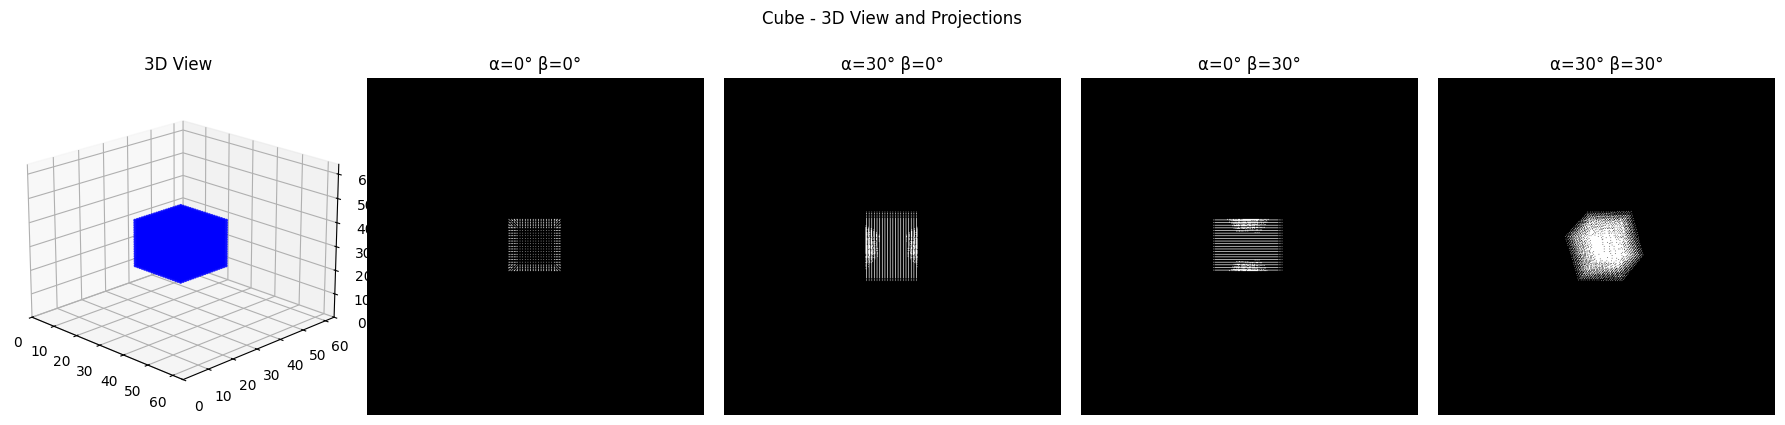


Visualizing Cylinder...


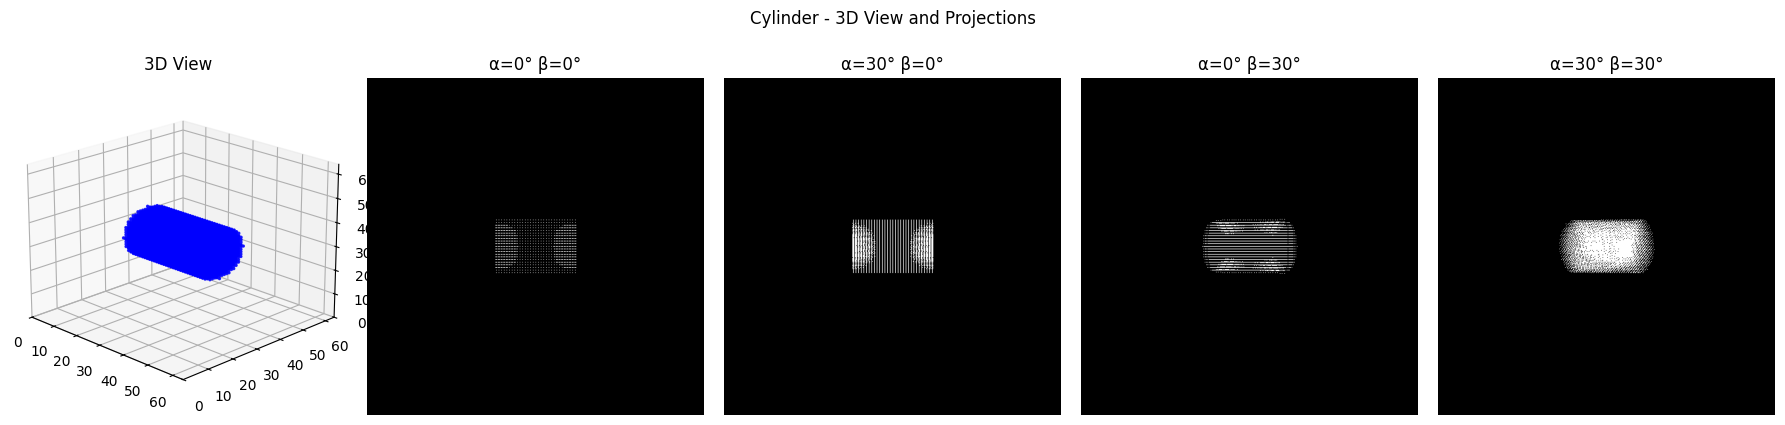


Visualizing Star...


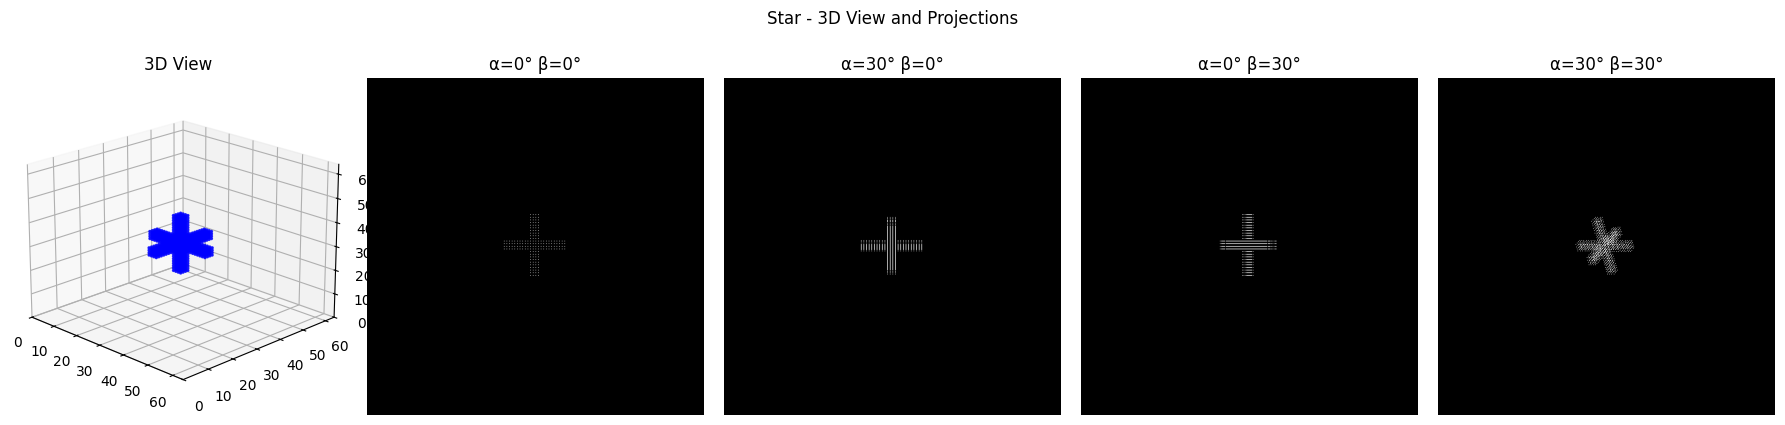


Visualizing Sphere...


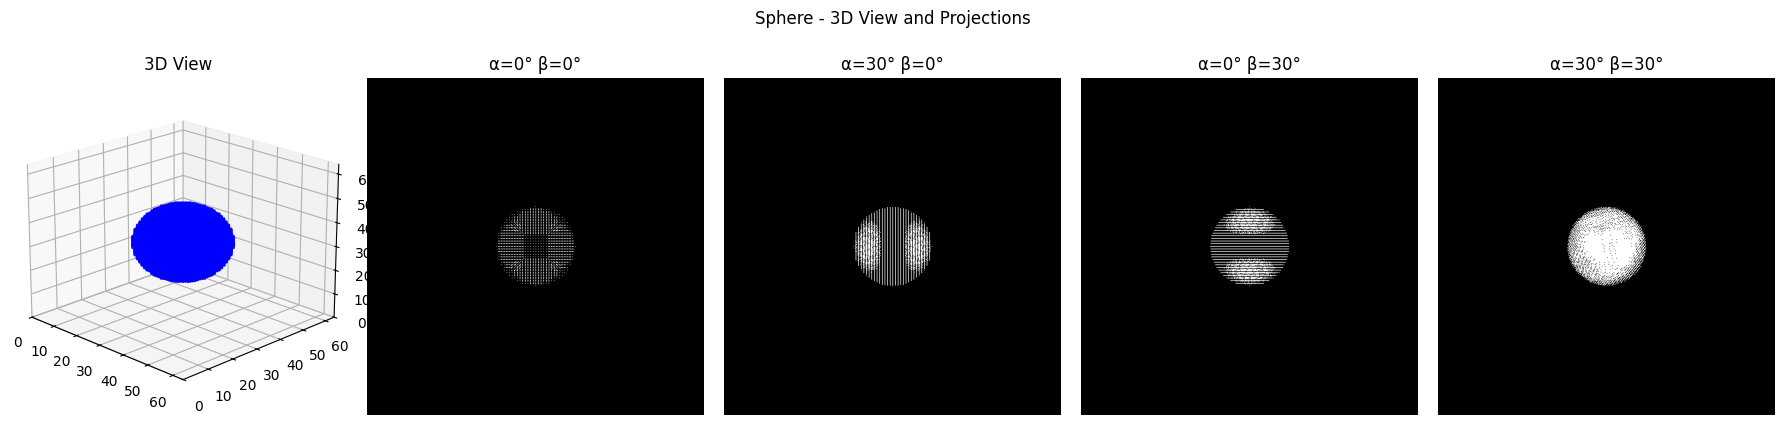


Visualizing Torus...


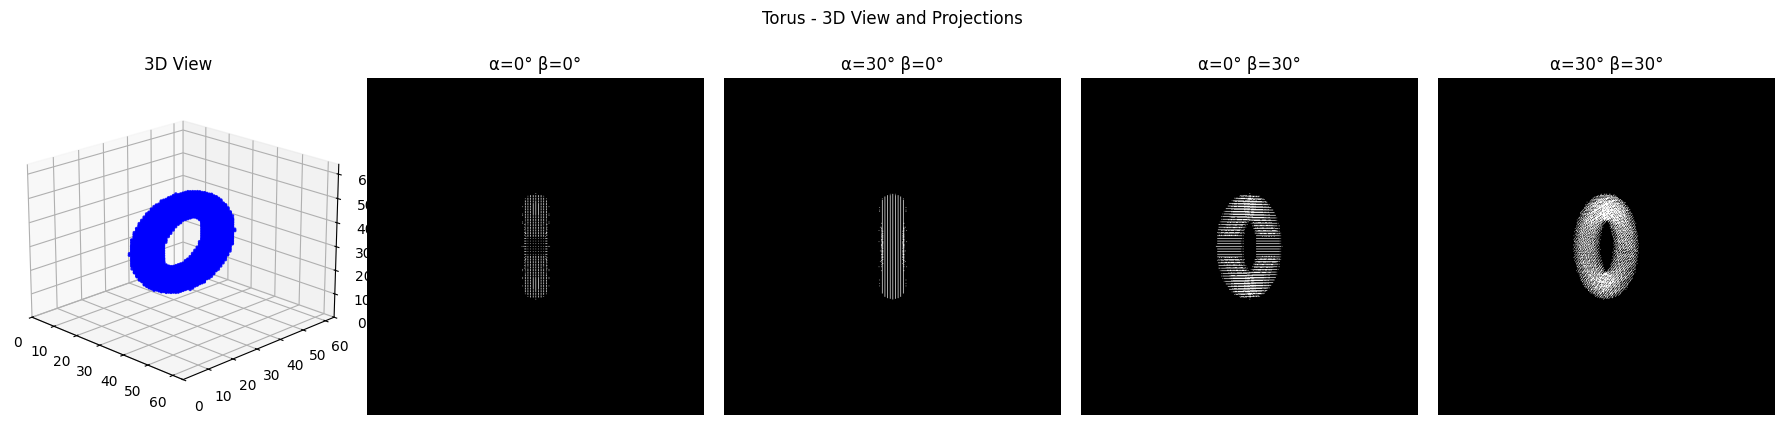


Visualizing Pyramid...


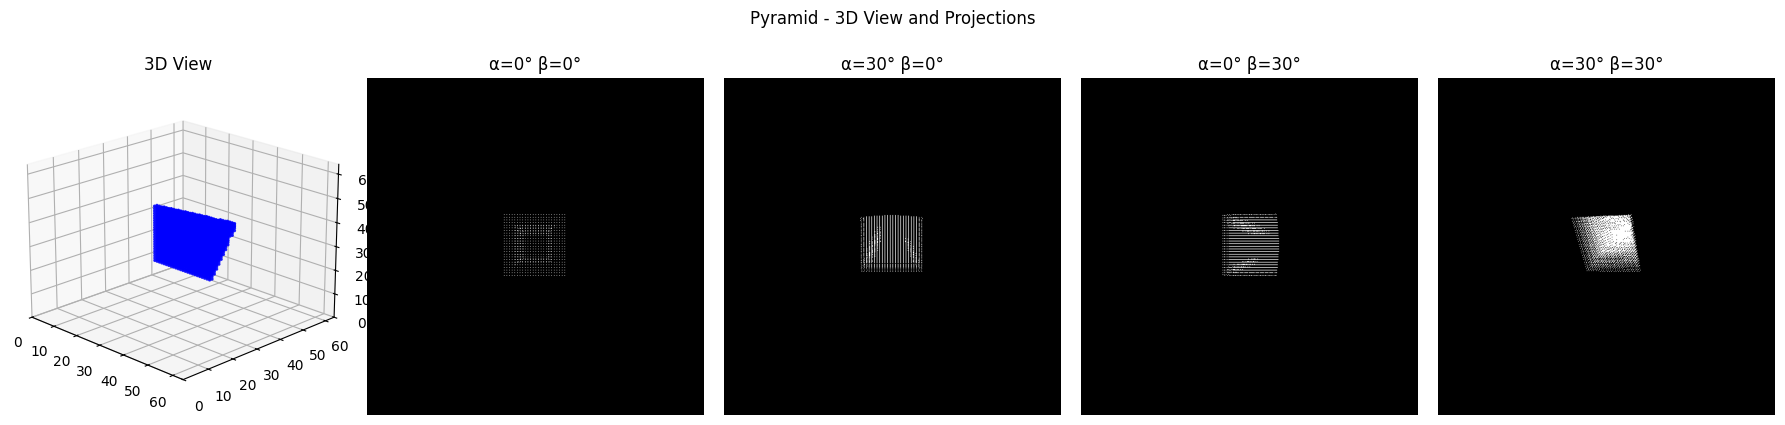


Visualizing Helix...


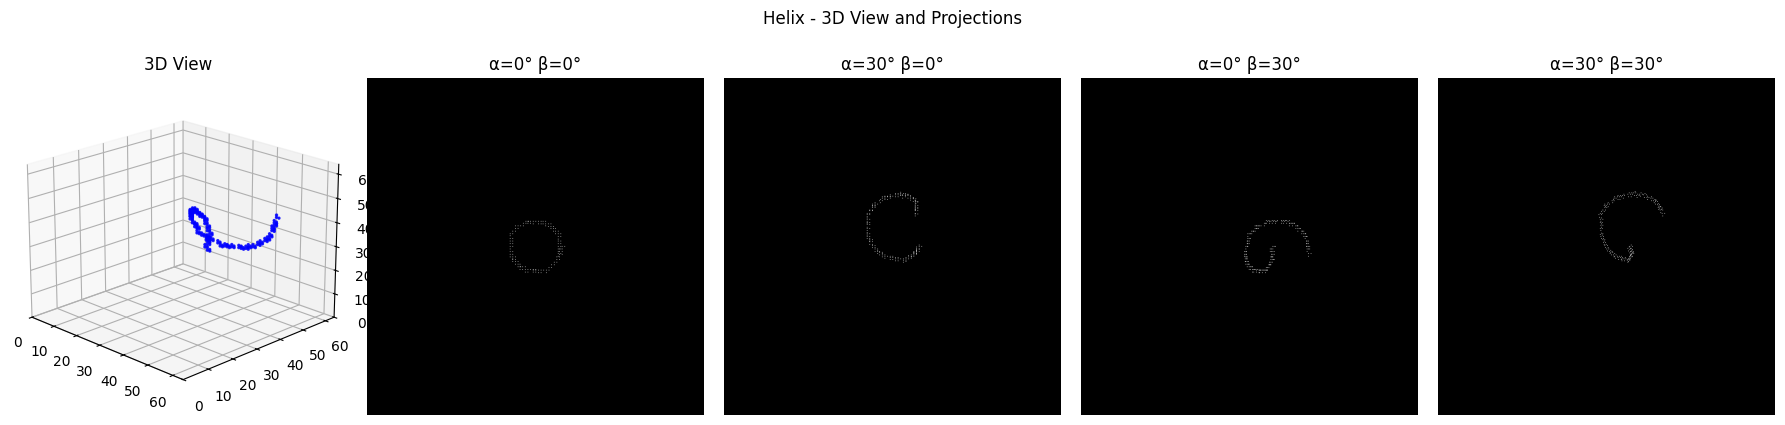


Visualizing CoronaryTree...


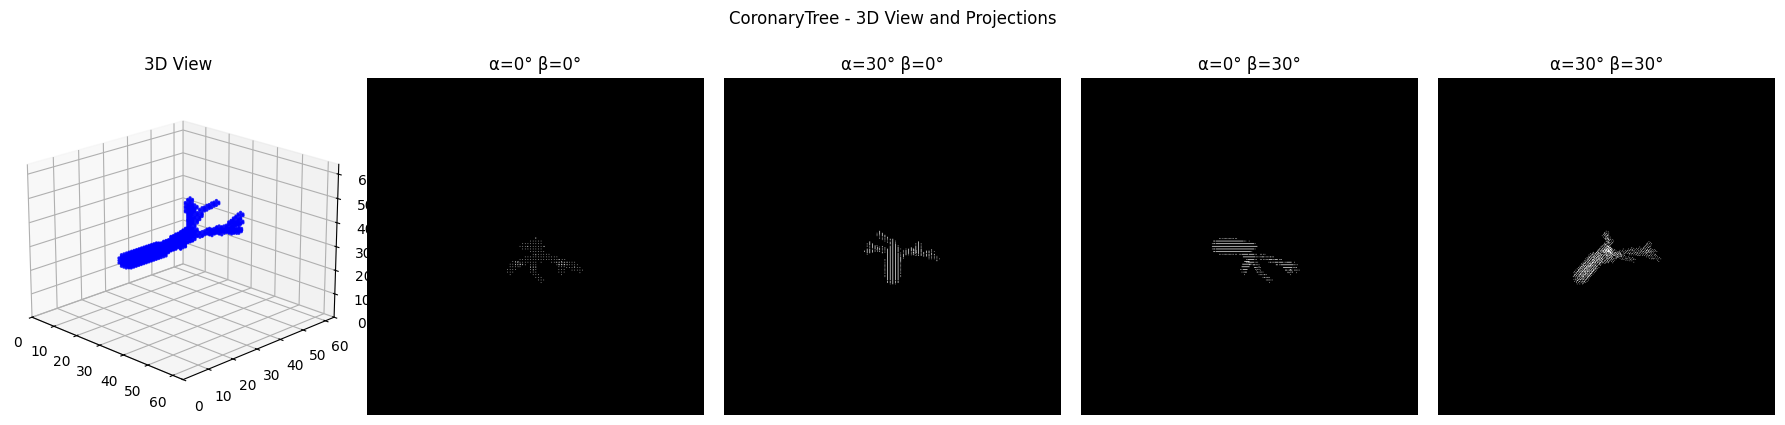

In [60]:
def plot_3d_voxels(voxels, title):
    """Visualize 3D voxels with consistent coordinate system"""
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    coords = torch.nonzero(voxels).cpu().numpy()
    if len(coords) > 0:
        # Plot as (X, Z, Y) to match projection views
        ax.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                  color='blue', s=2, alpha=0.8, depthshade=True)
    
    ax.set_xlabel('X (Horizontal)')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y (Vertical)')
    ax.set_title(title, pad=10)
    ax.set_xlim(0, voxels.shape[2])
    ax.set_ylim(0, voxels.shape[0])
    ax.set_zlim(0, voxels.shape[1])
    ax.view_init(elev=20, azim=-45)  # Standard isometric view
    plt.tight_layout()
    plt.show()

def visualize_all_objects(test_objects, projector):
    """Visualize 3D objects and their X-ray projections"""
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, obj_volume in test_objects.items():
        print(f"\nVisualizing {obj_name}...")
        
        # Combined visualization
        fig = plt.figure(figsize=(18, 4))
        fig.suptitle(f'{obj_name} - 3D View and Projections', y=1.05)
        
        # 3D View (subplot 1)
        ax_3d = fig.add_subplot(1, 5, 1, projection='3d')
        coords = torch.nonzero(obj_volume).cpu().numpy()
        if len(coords) > 0:
            ax_3d.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                         color='blue', s=2, alpha=0.8)
        ax_3d.set_title('3D View')
        ax_3d.set_xlim(0, obj_volume.shape[2])
        ax_3d.set_ylim(0, obj_volume.shape[0])
        ax_3d.set_zlim(0, obj_volume.shape[1])
        ax_3d.view_init(elev=20, azim=-45)
        
        # Projections (subplots 2-5)
        for i, (alpha, beta) in enumerate(angles):
            ax = fig.add_subplot(1, 5, i+2)
            proj_image = projector.project_volume(obj_volume, alpha, beta)#check proj_image is binary or not
            #np.savetxt('output.csv', proj_image.cpu().numpy(), delimiter=',')
            ax.imshow(proj_image.cpu().numpy(), cmap='gray')
            ax.set_title(f'α={math.degrees(alpha):.0f}° β={math.degrees(beta):.0f}°')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Initialize and run visualization
volume_shape = (64, 64, 64)
projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
test_objects = create_test_objects(volume_shape)
visualize_all_objects(test_objects, projector)

### 3. Reconstruction

#### 3.1 Reconstruction Framework (including visualization for evaluation)

In [13]:
def reconstruct_from_projections(test_objects, projector, num_iterations=5000, lr=0.01):
    """Reconstruct 3D objects from their projections using optimization"""
    results = {}
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nReconstructing {obj_name}...")
        
        # 1. Get the ground truth projections (I_k)
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            #print(I_k.float().max(),I_k.float().min())
            projection_matrices.append(P)

        #P = projection_matrices[0]
        #test_input = torch.ones(volume_shape).flatten().to(device)
        #output = torch.sparse.mm(P, test_input.unsqueeze(-1)).max()
        #print(f"全1输入时的最大投影值: {output.item()}")  # 如果>>1，说明需要归一化

        #P = projection_matrices[0]
        #print(f"Projection matrix max value: {P._values().max().item()}")
        #if P._values().max() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().max())
        #print(f"Projection matrix min value: {P._values().min().item()}")
        #if P._values().min() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().min())
        
        # 2. Initialize the reconstructed volume (relaxed to [0,1])
        X_recon = torch.rand(projector.volume_shape, device=device, requires_grad=True)
        
        # 3. Set up optimizer
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        
        # 4. Optimization loop
        loss_history = []
        best_loss = float('inf')
        best_X = None
        
        for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            
            # Compute all projections
            total_loss = 0
            vec_X = X_recon.flatten()
            
            for P, I_k in zip(projection_matrices, projections):
                # Compute P·vec(X)
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                #proj = proj.reshape(I_k.shape)# 不加max operator（也就是可能存在很多值为1的cube投影到同一个pixel）
                proj = proj.clamp(max=1.0).reshape(I_k.shape)
                
                # Compute Frobenius norm squared
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # Add regularization to encourage binary solutions
            # This helps push values toward 0 or 1
            #reg = torch.norm(X_recon * (1 - X_recon), p=1)  # Encourages values to be 0 or 1
            #total_loss += 5 * reg
            
            # Track best solution
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_X = X_recon.detach().clone()
            
            loss_history.append(total_loss.item())
            
            # Backpropagate and update
            total_loss.backward()
            if iteration % 100 == 0:
                grad_norm = X_recon.grad.norm().item()
                print(f"Iter {iter}: Loss={total_loss.item():.2f}, Grad Norm={grad_norm:.4f}")
            optimizer.step()
            
            # Project back to [0,1] range
            with torch.no_grad():
                X_recon.data = torch.clamp(X_recon, 0, 1)

        print(total_loss)

def visualize_reconstruction_results(results):
    """Visualize true and reconstructed volumes"""
    for obj_name, data in results.items():
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f'Reconstruction Results for {obj_name}', y=1.05)
        
        # True volume
        ax1 = fig.add_subplot(131, projection='3d')
        coords = torch.nonzero(data['true']).cpu().numpy()
        if len(coords) > 0:
            ax1.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                      color='blue', s=2, alpha=0.8)
        ax1.set_title('True Volume')
        ax1.set_xlim(0, data['true'].shape[2])
        ax1.set_ylim(0, data['true'].shape[0])
        ax1.set_zlim(0, data['true'].shape[1])
        ax1.view_init(elev=20, azim=-45)
        
        # Reconstructed volume (binary)
        ax2 = fig.add_subplot(132, projection='3d')
        coords = torch.nonzero(data['reconstructed']).cpu().numpy()
        if len(coords) > 0:
            ax2.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                       color='red', s=2, alpha=0.8)
        ax2.set_title('Reconstructed Volume')
        ax2.set_xlim(0, data['reconstructed'].shape[2])
        ax2.set_ylim(0, data['reconstructed'].shape[0])
        ax2.set_zlim(0, data['reconstructed'].shape[1])
        ax2.view_init(elev=20, azim=-45)
        
        # Loss curve
        ax3 = fig.add_subplot(133)
        ax3.plot(data['loss_history'])
        ax3.set_title('Optimization Loss')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

#### 3.2 Some necessary regular test before reconstruction


Testing with Ground Truth Initialization: Cube
Initial Loss (should be 0): 0.000000
Iter 0: Loss=0.000000, Grad Norm=0.000000
Iter 10: Loss=0.000000, Grad Norm=0.000000
Iter 20: Loss=0.000000, Grad Norm=0.000000
Iter 30: Loss=0.000000, Grad Norm=0.000000
Iter 40: Loss=0.000000, Grad Norm=0.000000
Iter 50: Loss=0.000000, Grad Norm=0.000000
Iter 60: Loss=0.000000, Grad Norm=0.000000
Iter 70: Loss=0.000000, Grad Norm=0.000000
Iter 80: Loss=0.000000, Grad Norm=0.000000
Iter 90: Loss=0.000000, Grad Norm=0.000000
Final Difference from Ground Truth: 0.000000

Testing with Ground Truth Initialization: Cylinder
Initial Loss (should be 0): 0.000000
Iter 0: Loss=0.000000, Grad Norm=0.000000
Iter 10: Loss=0.000000, Grad Norm=0.000000
Iter 20: Loss=0.000000, Grad Norm=0.000000
Iter 30: Loss=0.000000, Grad Norm=0.000000
Iter 40: Loss=0.000000, Grad Norm=0.000000
Iter 50: Loss=0.000000, Grad Norm=0.000000
Iter 60: Loss=0.000000, Grad Norm=0.000000
Iter 70: Loss=0.000000, Grad Norm=0.000000
Iter 80: 

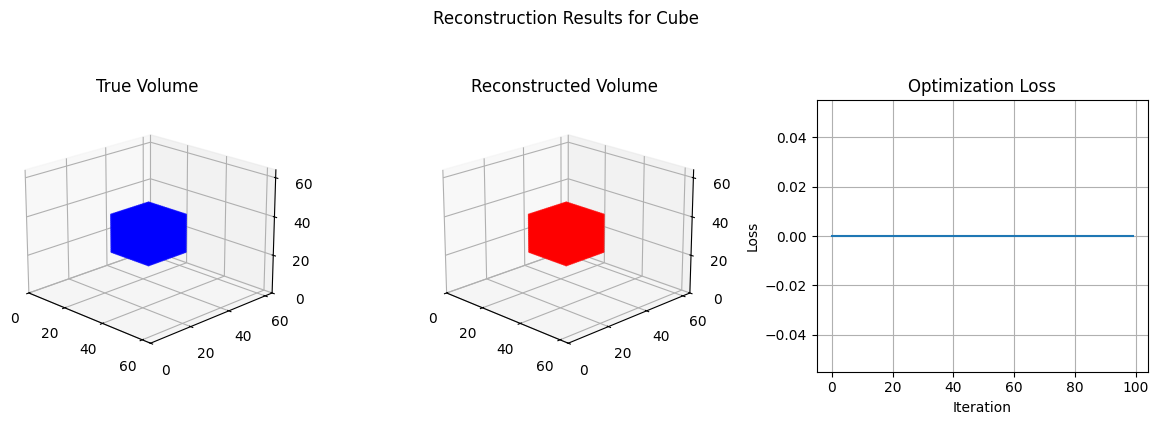

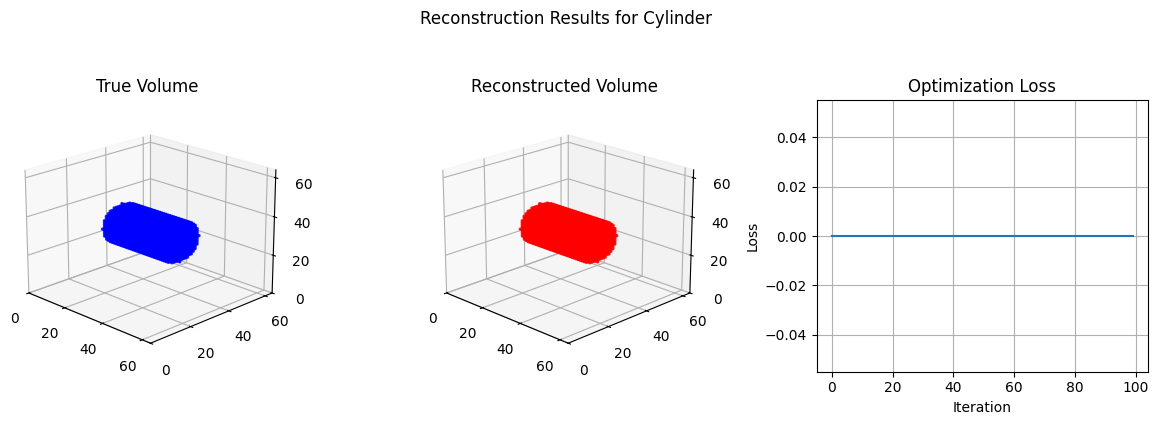

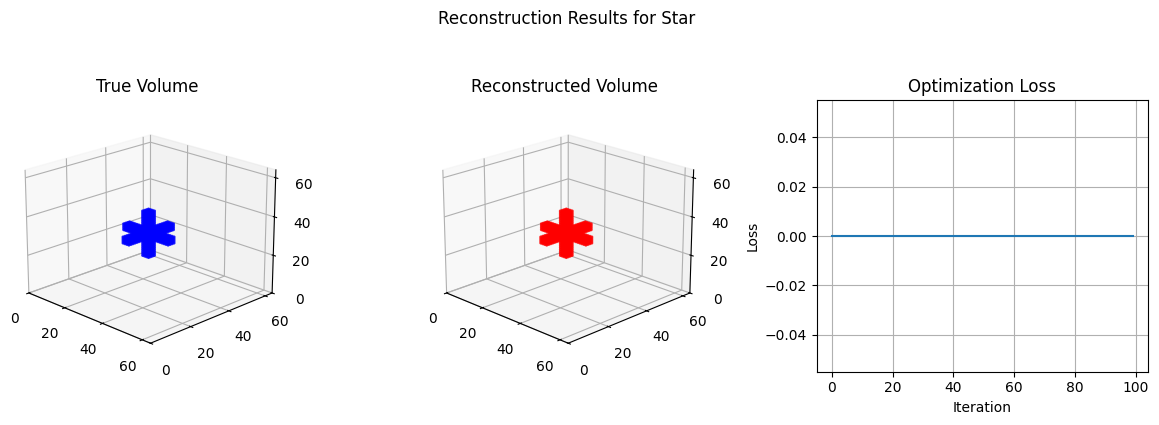

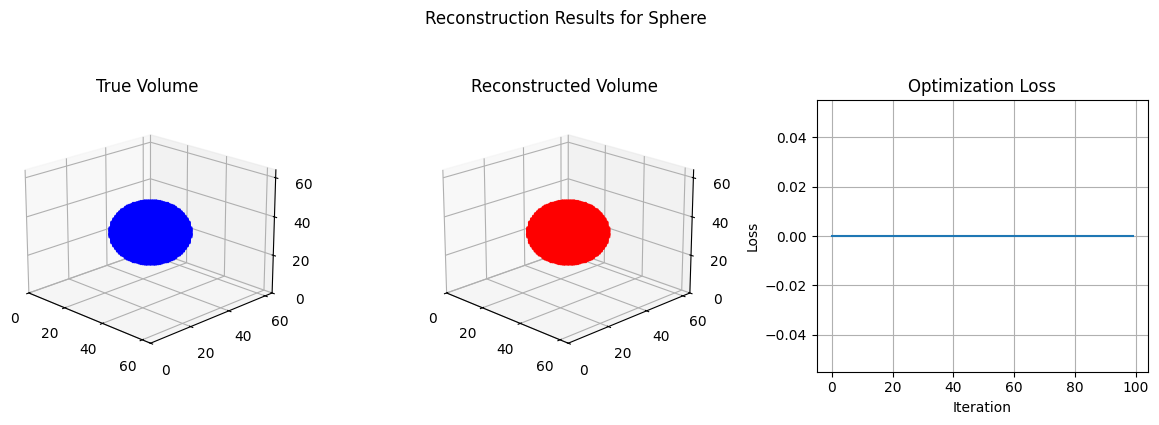

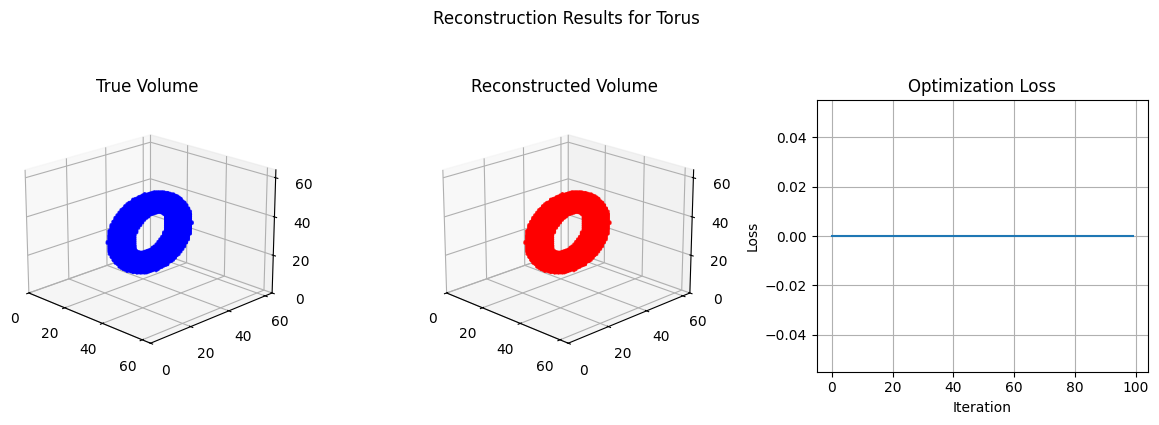

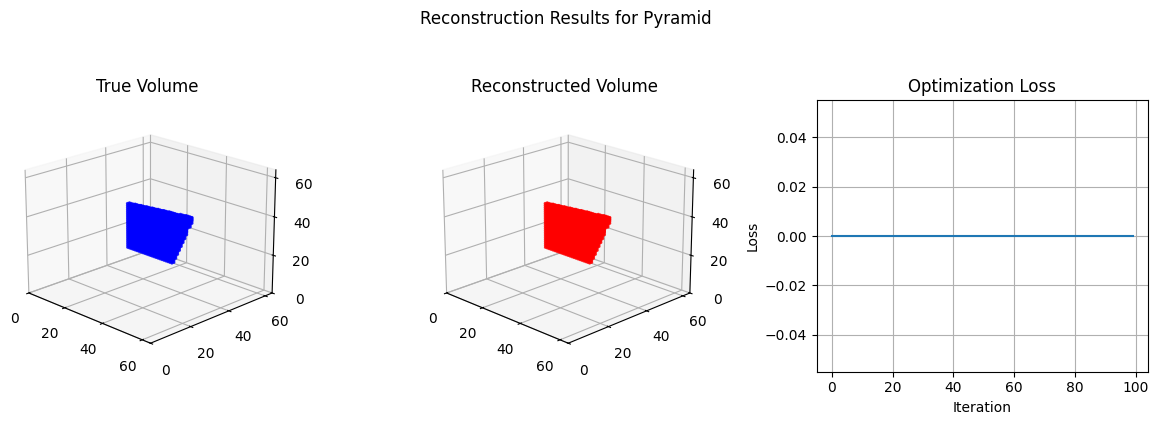

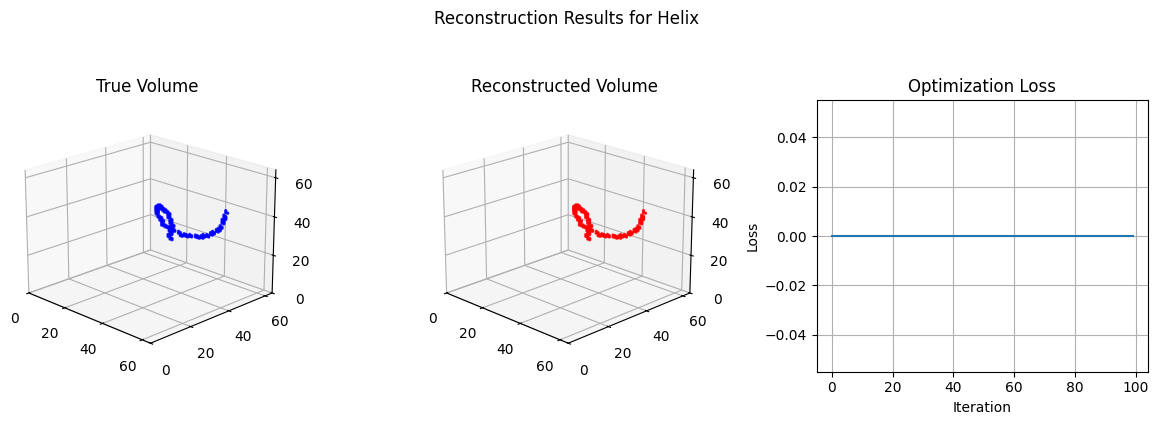

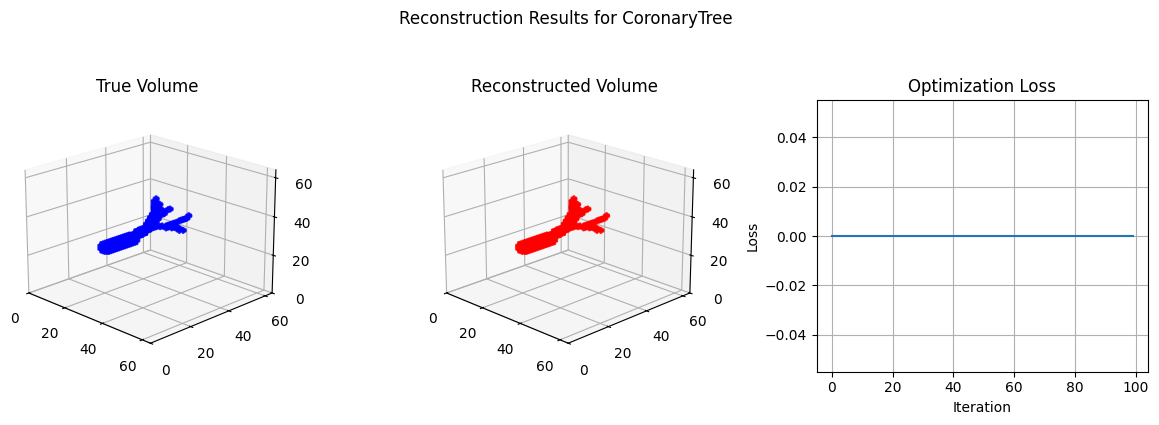

In [14]:
def reconstruct_with_ground_truth_init(test_objects, projector, num_iterations=100, lr=0.001):
    """使用ground truth作为initialization进行验证性优化，如果优化loss为0则优化过程没问题"""
    results = {}
    angles = [(0,0), (math.pi/6,0), (0,math.pi/6), (math.pi/6,math.pi/6)]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nTesting with Ground Truth Initialization: {obj_name}")
        
        # 1. projection data:
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            projection_matrices.append(P)

        # 2. use ground truth as initialization:
        X_recon = true_volume.clone().float().requires_grad_(True)
        
        # 3. optimizer:
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        loss_history = []

        # 4. optimization:
        for iteration in range(num_iterations):
            optimizer.zero_grad()
            
            # loss calculation:
            total_loss = 0
            vec_X = X_recon.flatten()
            for P, I_k in zip(projection_matrices, projections):
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                proj = proj.clamp(max=1.0).reshape(I_k.shape)
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # print loss
            if iteration == 0:
                print(f"Initial Loss (should be 0): {total_loss.item():.6f}")
            
            loss_history.append(total_loss.item())
            
            total_loss.backward()
            optimizer.step()
            
            # print gradient norm
            if iteration % 10 == 0:
                grad_norm = X_recon.grad.norm().item() if X_recon.grad is not None else 0.0
                print(f"Iter {iteration}: Loss={total_loss.item():.6f}, Grad Norm={grad_norm:.6f}")

        # 5. final result:
        diff = torch.norm(X_recon - true_volume).item()
        print(f"Final Difference from Ground Truth: {diff:.6f}")
        
        # store results:
        results[obj_name] = {
            'true': true_volume,
            'reconstructed': X_recon.detach(),
            'loss_history': loss_history
        }
    
    return results

if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    # use GT for validation
    reconstruction_results = reconstruct_with_ground_truth_init(test_objects, projector)
    
    # visualization (GT = reconstruction)
    visualize_reconstruction_results(reconstruction_results)

In [24]:
def validate_ground_truth_loss(test_objects, projector):#检验是否ground truth的loss等于0
    """validate loss of ground truth equal to 0"""
    angles = [(0,0), (math.pi/6,0), (0,math.pi/6), (math.pi/6,math.pi/6)]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nValidating {obj_name}...")
        total_loss = 0
        
        # 计算ground truth的loss
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)

            true_volume_float = true_volume.float()  # 转换为FloatTensor
            true_volume_flat = true_volume_float.flatten().unsqueeze(-1)
            
            # 计算P·vec(X_blue)
            proj = torch.sparse.mm(P, true_volume_flat).squeeze()
            proj = proj.reshape(I_k.shape).clamp(max=1.0)  # 与重建时一致
            
            loss = torch.norm(proj - I_k.float(), p='fro')**2
            total_loss += loss
            print(f"View ({alpha:.2f}, {beta:.2f}) Loss: {loss.item():.2f}")
        
        print(f"Total Loss for {obj_name}: {total_loss.item():.2f} (should be 0)")

if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    # validate ground truth
    validate_ground_truth_loss(test_objects, projector)

<class 'torch.Tensor'>
<class 'torch.Tensor'>

Validating Cube...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Cube: 0.00 (should be 0)

Validating Cylinder...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Cylinder: 0.00 (should be 0)

Validating Star...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Star: 0.00 (should be 0)

Validating Sphere...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Sphere: 0.00 (should be 0)

Validating Torus...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Torus: 0.00 (should be 0)

Validating Pyramid...
View (0.00, 0.00) Loss: 0.00
View (0.

#### 3.3 Reconstruction process


Visualizing Cube...


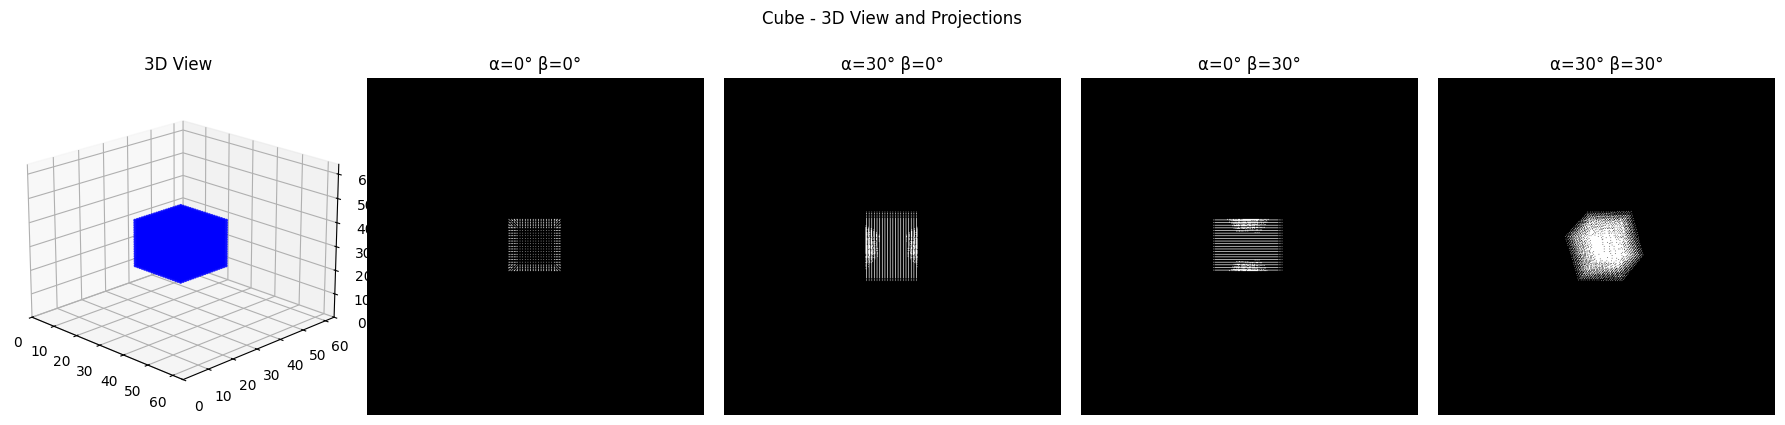


Visualizing Cylinder...


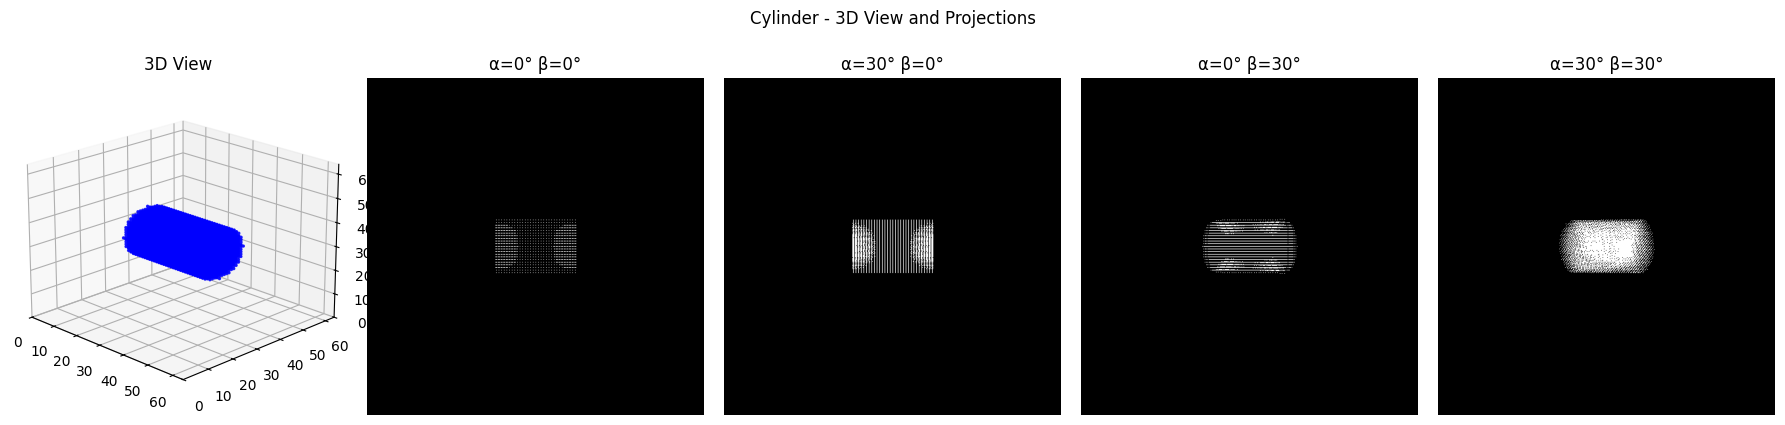


Visualizing Star...


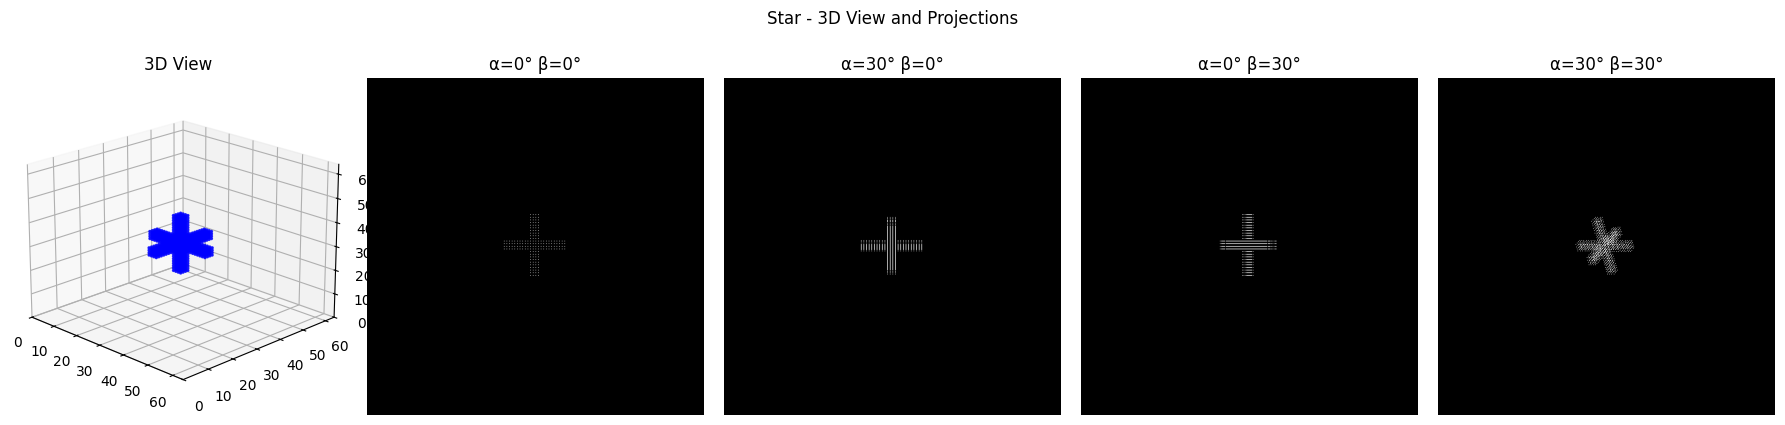


Visualizing Sphere...


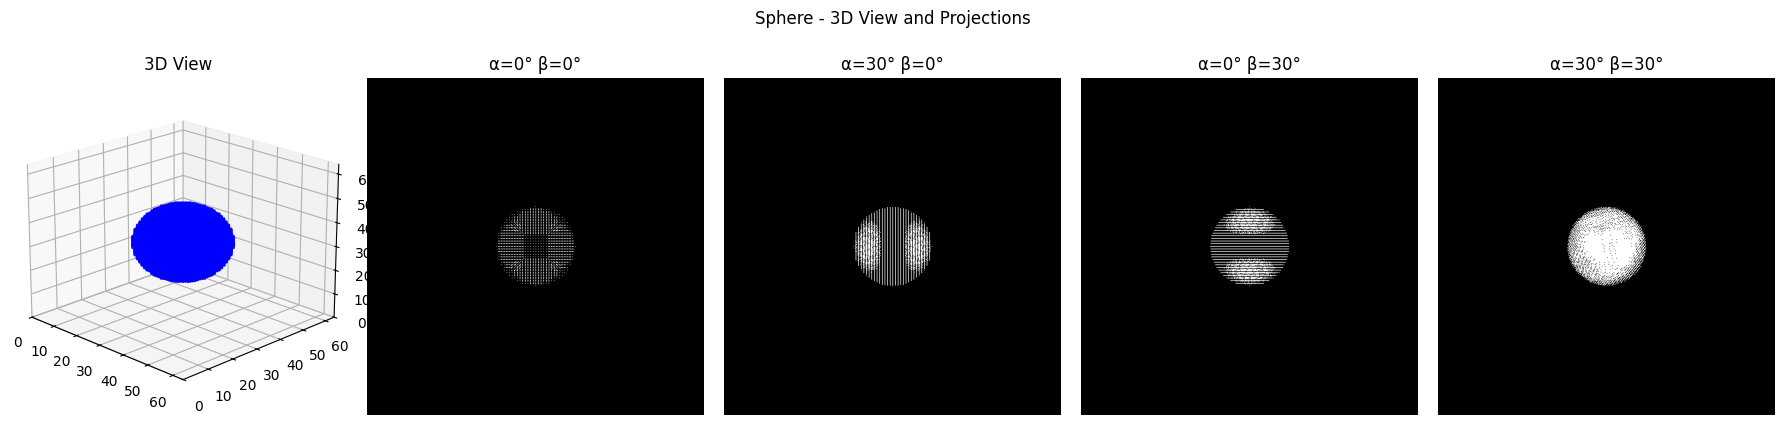


Visualizing Torus...


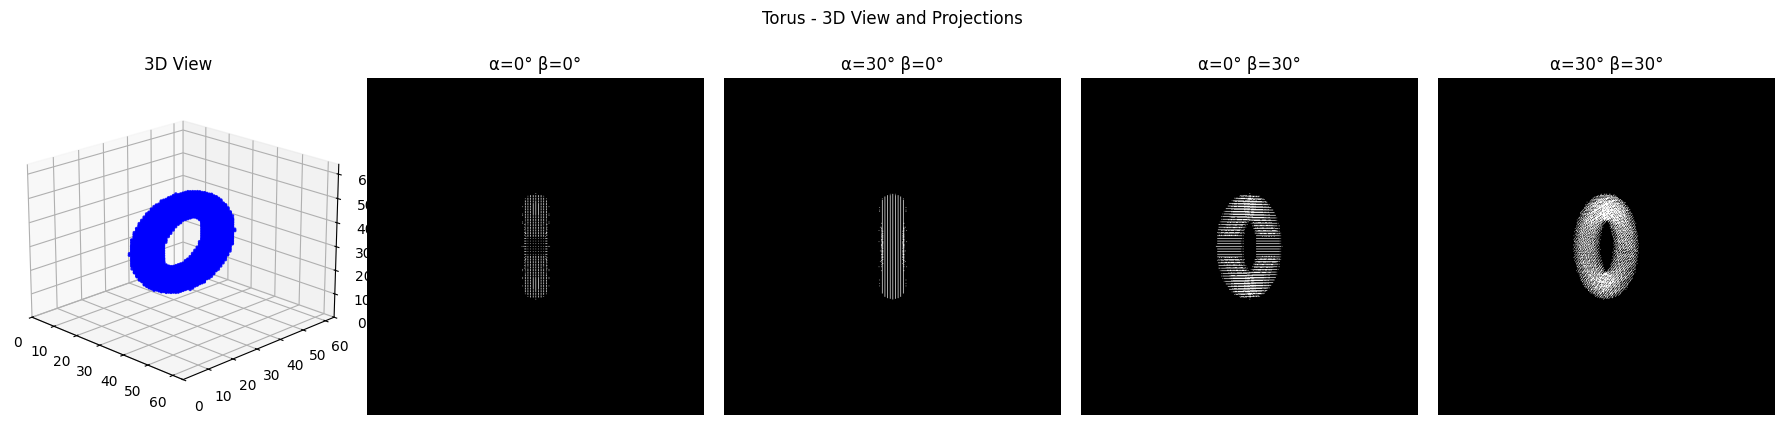


Visualizing Pyramid...


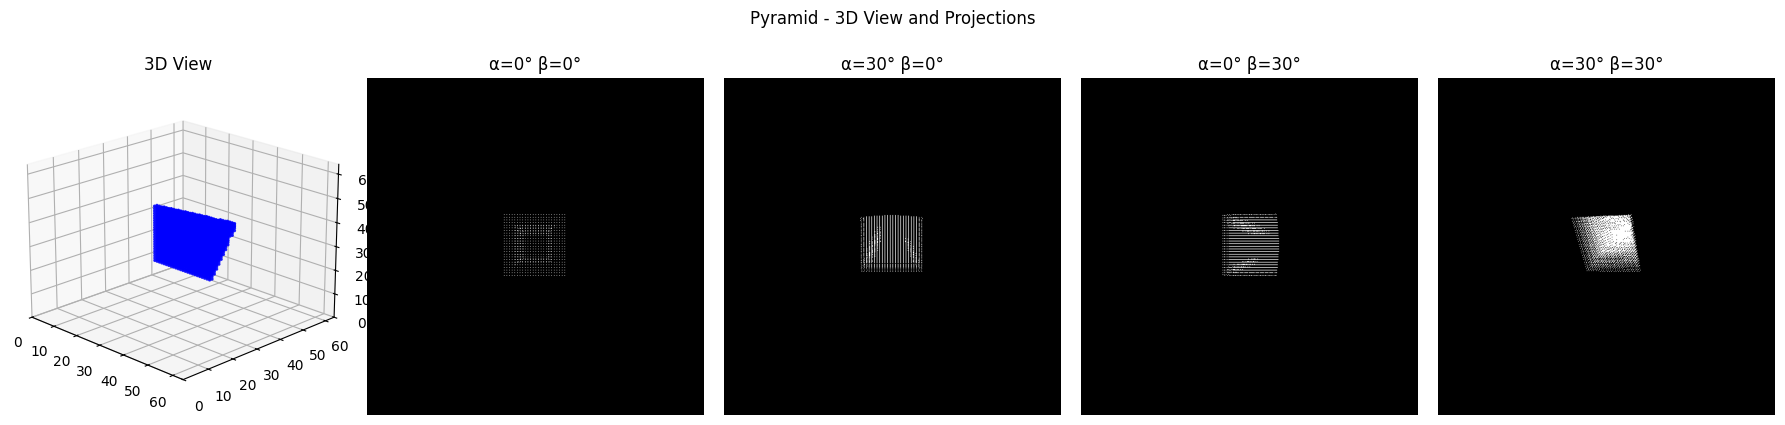


Visualizing Helix...


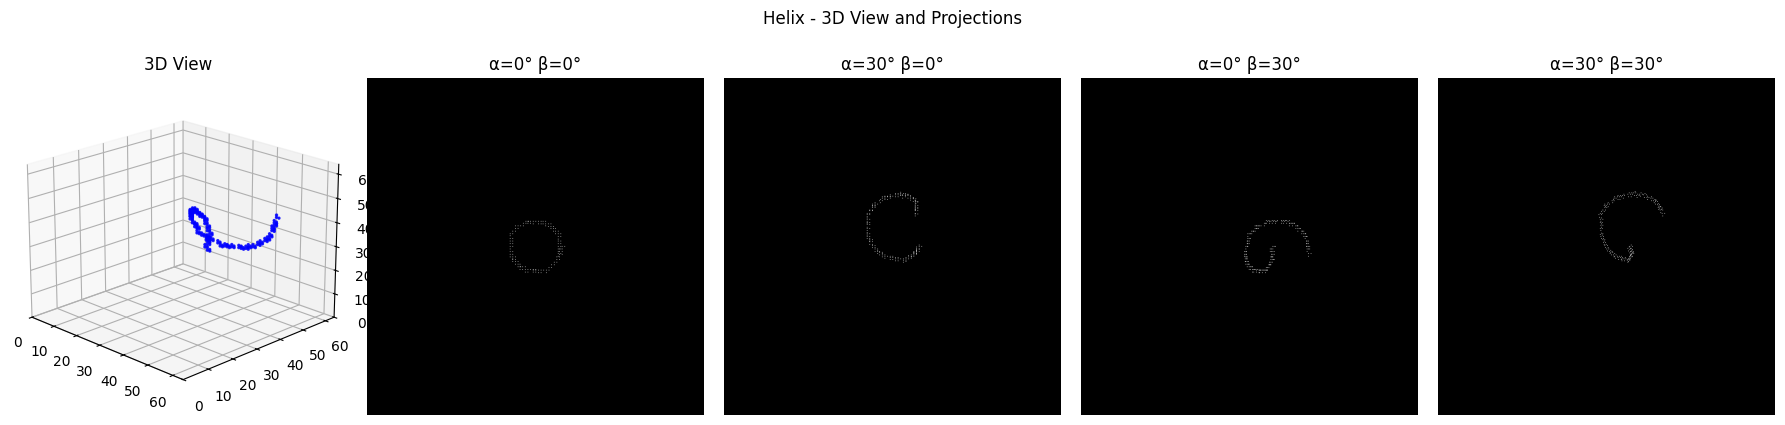


Visualizing CoronaryTree...


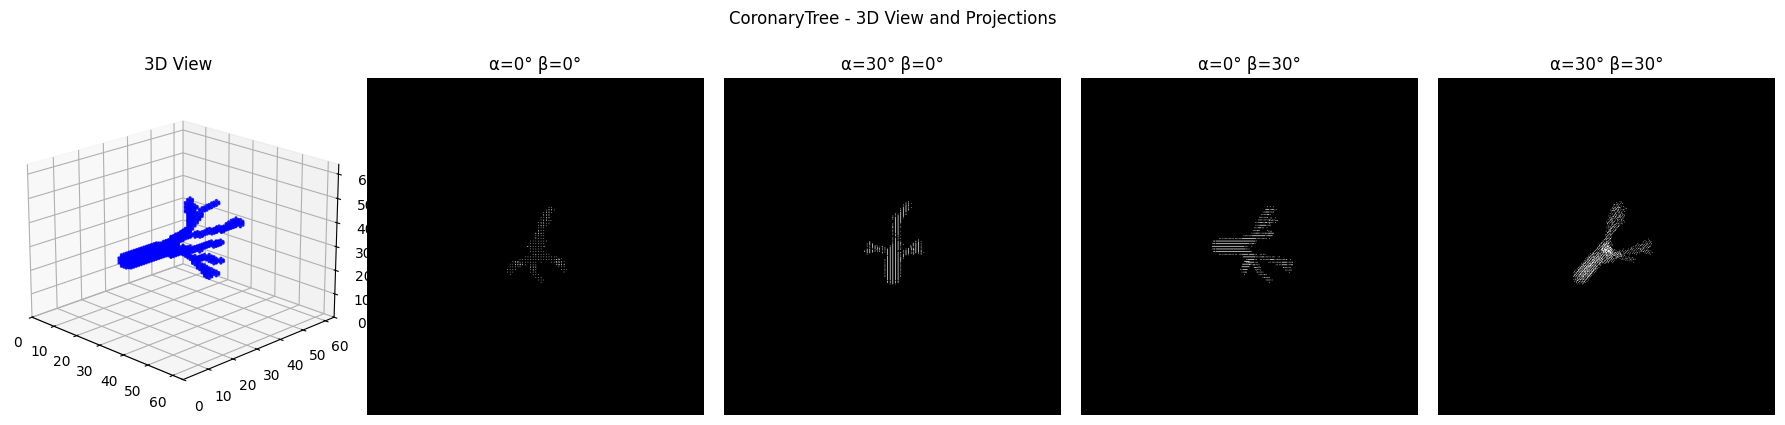


Reconstructing Cube...


  0%|          | 0/3500 [00:00<?, ?it/s]

Iter <built-in function iter>: Loss=1779200.88, Grad Norm=13053.1543


  3%|▎         | 106/3500 [00:02<01:05, 51.99it/s]

Iter <built-in function iter>: Loss=47557.32, Grad Norm=1567.2388


  6%|▌         | 208/3500 [00:04<01:02, 52.42it/s]

Iter <built-in function iter>: Loss=9890.61, Grad Norm=482.9802


  9%|▉         | 310/3500 [00:06<01:03, 50.42it/s]

Iter <built-in function iter>: Loss=8885.12, Grad Norm=470.8693


 12%|█▏        | 406/3500 [00:08<01:01, 50.55it/s]

Iter <built-in function iter>: Loss=8261.04, Grad Norm=460.3127


 15%|█▍        | 508/3500 [00:10<00:57, 52.16it/s]

Iter <built-in function iter>: Loss=7866.68, Grad Norm=451.3377


 17%|█▋        | 610/3500 [00:11<00:55, 51.74it/s]

Iter <built-in function iter>: Loss=7646.83, Grad Norm=442.6787


 20%|██        | 712/3500 [00:13<00:53, 51.69it/s]

Iter <built-in function iter>: Loss=7512.76, Grad Norm=436.9739


 23%|██▎       | 808/3500 [00:15<00:51, 51.85it/s]

Iter <built-in function iter>: Loss=7428.93, Grad Norm=433.4736


 26%|██▌       | 910/3500 [00:17<00:51, 50.30it/s]

Iter <built-in function iter>: Loss=7377.40, Grad Norm=431.5666


 29%|██▊       | 1006/3500 [00:19<00:48, 51.84it/s]

Iter <built-in function iter>: Loss=7350.16, Grad Norm=430.3916


 32%|███▏      | 1108/3500 [00:21<00:46, 51.87it/s]

Iter <built-in function iter>: Loss=7332.14, Grad Norm=428.7921


 35%|███▍      | 1210/3500 [00:23<00:43, 52.07it/s]

Iter <built-in function iter>: Loss=7322.38, Grad Norm=427.6617


 37%|███▋      | 1306/3500 [00:25<00:42, 51.34it/s]

Iter <built-in function iter>: Loss=7316.92, Grad Norm=427.6670


 40%|████      | 1408/3500 [00:27<00:40, 51.80it/s]

Iter <built-in function iter>: Loss=7312.91, Grad Norm=426.9745


 43%|████▎     | 1510/3500 [00:29<00:38, 51.48it/s]

Iter <built-in function iter>: Loss=7310.41, Grad Norm=426.5981


 46%|████▌     | 1612/3500 [00:31<00:36, 52.02it/s]

Iter <built-in function iter>: Loss=7309.78, Grad Norm=426.3572


 49%|████▉     | 1708/3500 [00:33<00:35, 50.59it/s]

Iter <built-in function iter>: Loss=7309.47, Grad Norm=426.3881


 52%|█████▏    | 1810/3500 [00:35<00:33, 50.89it/s]

Iter <built-in function iter>: Loss=7309.27, Grad Norm=426.1333


 54%|█████▍    | 1906/3500 [00:37<00:30, 51.48it/s]

Iter <built-in function iter>: Loss=7309.43, Grad Norm=426.8925


 57%|█████▋    | 2008/3500 [00:39<00:28, 52.30it/s]

Iter <built-in function iter>: Loss=7309.33, Grad Norm=427.0453


 60%|██████    | 2110/3500 [00:41<00:27, 51.11it/s]

Iter <built-in function iter>: Loss=7309.32, Grad Norm=426.1933


 63%|██████▎   | 2211/3500 [00:43<00:25, 51.38it/s]

Iter <built-in function iter>: Loss=7309.52, Grad Norm=425.7393


 66%|██████▌   | 2307/3500 [00:44<00:22, 51.96it/s]

Iter <built-in function iter>: Loss=7309.61, Grad Norm=426.9595


 69%|██████▉   | 2409/3500 [00:46<00:21, 51.82it/s]

Iter <built-in function iter>: Loss=7309.52, Grad Norm=425.9045


 72%|███████▏  | 2511/3500 [00:48<00:19, 51.84it/s]

Iter <built-in function iter>: Loss=7309.87, Grad Norm=426.4630


 74%|███████▍  | 2607/3500 [00:50<00:17, 50.85it/s]

Iter <built-in function iter>: Loss=7309.69, Grad Norm=426.1827


 77%|███████▋  | 2709/3500 [00:52<00:15, 52.00it/s]

Iter <built-in function iter>: Loss=7309.77, Grad Norm=425.9351


 80%|████████  | 2811/3500 [00:54<00:13, 51.80it/s]

Iter <built-in function iter>: Loss=7310.01, Grad Norm=426.9176


 83%|████████▎ | 2907/3500 [00:56<00:11, 51.58it/s]

Iter <built-in function iter>: Loss=7310.11, Grad Norm=427.1143


 86%|████████▌ | 3009/3500 [00:58<00:09, 51.60it/s]

Iter <built-in function iter>: Loss=7310.26, Grad Norm=427.0605


 89%|████████▉ | 3111/3500 [01:00<00:07, 51.66it/s]

Iter <built-in function iter>: Loss=7310.51, Grad Norm=426.7469


 92%|█████████▏| 3207/3500 [01:02<00:05, 51.82it/s]

Iter <built-in function iter>: Loss=7310.50, Grad Norm=427.2830


 95%|█████████▍| 3309/3500 [01:04<00:03, 51.91it/s]

Iter <built-in function iter>: Loss=7310.32, Grad Norm=426.0361


 97%|█████████▋| 3411/3500 [01:06<00:01, 50.80it/s]

Iter <built-in function iter>: Loss=7310.74, Grad Norm=427.0193


100%|██████████| 3500/3500 [01:07<00:00, 51.49it/s]


tensor(7310.5083, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Cylinder...


  0%|          | 6/3500 [00:00<01:09, 50.19it/s]

Iter <built-in function iter>: Loss=1757490.38, Grad Norm=12953.1963


  3%|▎         | 108/3500 [00:02<01:05, 51.68it/s]

Iter <built-in function iter>: Loss=49531.99, Grad Norm=1544.2787


  6%|▌         | 210/3500 [00:04<01:03, 51.82it/s]

Iter <built-in function iter>: Loss=12432.91, Grad Norm=510.3274


  9%|▉         | 309/3500 [00:06<01:04, 49.36it/s]

Iter <built-in function iter>: Loss=11064.12, Grad Norm=497.1455


 12%|█▏        | 410/3500 [00:08<01:00, 51.30it/s]

Iter <built-in function iter>: Loss=10237.73, Grad Norm=485.6510


 15%|█▍        | 509/3500 [00:09<00:59, 49.98it/s]

Iter <built-in function iter>: Loss=9736.00, Grad Norm=476.9628


 17%|█▋        | 610/3500 [00:12<00:58, 49.43it/s]

Iter <built-in function iter>: Loss=9441.79, Grad Norm=469.9980


 20%|██        | 706/3500 [00:13<00:55, 49.90it/s]

Iter <built-in function iter>: Loss=9270.82, Grad Norm=462.5517


 23%|██▎       | 806/3500 [00:15<00:52, 51.39it/s]

Iter <built-in function iter>: Loss=9172.00, Grad Norm=460.5443


 26%|██▌       | 908/3500 [00:17<00:50, 51.58it/s]

Iter <built-in function iter>: Loss=9110.10, Grad Norm=457.6631


 29%|██▉       | 1010/3500 [00:19<00:48, 51.60it/s]

Iter <built-in function iter>: Loss=9067.57, Grad Norm=456.2146


 32%|███▏      | 1106/3500 [00:21<00:47, 50.38it/s]

Iter <built-in function iter>: Loss=9043.02, Grad Norm=455.4589


 35%|███▍      | 1208/3500 [00:23<00:44, 51.39it/s]

Iter <built-in function iter>: Loss=9027.63, Grad Norm=453.6858


 37%|███▋      | 1310/3500 [00:25<00:43, 50.91it/s]

Iter <built-in function iter>: Loss=9018.15, Grad Norm=454.3428


 40%|████      | 1406/3500 [00:27<00:40, 51.23it/s]

Iter <built-in function iter>: Loss=9012.19, Grad Norm=453.8964


 43%|████▎     | 1508/3500 [00:29<00:39, 50.16it/s]

Iter <built-in function iter>: Loss=9010.22, Grad Norm=453.8943


 46%|████▌     | 1606/3500 [00:31<00:37, 50.99it/s]

Iter <built-in function iter>: Loss=9008.92, Grad Norm=452.7997


 49%|████▉     | 1708/3500 [00:33<00:34, 51.30it/s]

Iter <built-in function iter>: Loss=9008.88, Grad Norm=453.4085


 52%|█████▏    | 1810/3500 [00:35<00:33, 50.91it/s]

Iter <built-in function iter>: Loss=9008.80, Grad Norm=453.8511


 54%|█████▍    | 1906/3500 [00:37<00:31, 51.12it/s]

Iter <built-in function iter>: Loss=9008.55, Grad Norm=451.3740


 57%|█████▋    | 2008/3500 [00:39<00:29, 51.13it/s]

Iter <built-in function iter>: Loss=9009.09, Grad Norm=453.6572


 60%|██████    | 2110/3500 [00:41<00:27, 50.59it/s]

Iter <built-in function iter>: Loss=9008.97, Grad Norm=451.9655


 63%|██████▎   | 2206/3500 [00:43<00:25, 50.60it/s]

Iter <built-in function iter>: Loss=9009.05, Grad Norm=452.5345


 66%|██████▌   | 2307/3500 [00:45<00:23, 49.75it/s]

Iter <built-in function iter>: Loss=9009.18, Grad Norm=452.8502


 69%|██████▉   | 2407/3500 [00:47<00:21, 50.44it/s]

Iter <built-in function iter>: Loss=9009.33, Grad Norm=453.7285


 72%|███████▏  | 2509/3500 [00:49<00:19, 50.40it/s]

Iter <built-in function iter>: Loss=9009.53, Grad Norm=453.0888


 75%|███████▍  | 2611/3500 [00:51<00:17, 50.81it/s]

Iter <built-in function iter>: Loss=9009.85, Grad Norm=453.5518


 77%|███████▋  | 2707/3500 [00:53<00:15, 51.06it/s]

Iter <built-in function iter>: Loss=9009.72, Grad Norm=453.4775


 80%|████████  | 2809/3500 [00:55<00:13, 51.20it/s]

Iter <built-in function iter>: Loss=9009.83, Grad Norm=452.2257


 83%|████████▎ | 2911/3500 [00:57<00:11, 50.88it/s]

Iter <built-in function iter>: Loss=9010.00, Grad Norm=452.8756


 86%|████████▌ | 3007/3500 [00:59<00:09, 50.73it/s]

Iter <built-in function iter>: Loss=9010.02, Grad Norm=453.1094


 89%|████████▉ | 3109/3500 [01:01<00:07, 49.67it/s]

Iter <built-in function iter>: Loss=9009.97, Grad Norm=451.9451


 92%|█████████▏| 3208/3500 [01:03<00:05, 50.01it/s]

Iter <built-in function iter>: Loss=9010.22, Grad Norm=453.2323


 95%|█████████▍| 3309/3500 [01:05<00:03, 50.68it/s]

Iter <built-in function iter>: Loss=9010.19, Grad Norm=452.8134


 97%|█████████▋| 3405/3500 [01:07<00:01, 50.51it/s]

Iter <built-in function iter>: Loss=9010.28, Grad Norm=452.9510


100%|██████████| 3500/3500 [01:08<00:00, 50.73it/s]


tensor(9010.2549, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Star...


  0%|          | 5/3500 [00:00<01:14, 46.65it/s]

Iter <built-in function iter>: Loss=1828556.38, Grad Norm=13343.4258


  3%|▎         | 106/3500 [00:02<01:07, 50.58it/s]

Iter <built-in function iter>: Loss=41651.23, Grad Norm=1650.4926


  6%|▌         | 208/3500 [00:04<01:05, 50.48it/s]

Iter <built-in function iter>: Loss=2186.37, Grad Norm=300.1312


  9%|▉         | 310/3500 [00:06<01:03, 50.35it/s]

Iter <built-in function iter>: Loss=1833.24, Grad Norm=281.7758


 12%|█▏        | 406/3500 [00:08<01:01, 49.99it/s]

Iter <built-in function iter>: Loss=1651.37, Grad Norm=267.1352


 15%|█▍        | 510/3500 [00:10<00:59, 50.10it/s]

Iter <built-in function iter>: Loss=1516.03, Grad Norm=250.8535


 17%|█▋        | 606/3500 [00:12<00:57, 50.48it/s]

Iter <built-in function iter>: Loss=1419.32, Grad Norm=244.3437


 20%|██        | 708/3500 [00:14<00:55, 50.15it/s]

Iter <built-in function iter>: Loss=1363.85, Grad Norm=241.2777


 23%|██▎       | 810/3500 [00:16<00:53, 50.49it/s]

Iter <built-in function iter>: Loss=1326.76, Grad Norm=238.1792


 26%|██▌       | 909/3500 [00:18<00:51, 50.12it/s]

Iter <built-in function iter>: Loss=1302.61, Grad Norm=237.9822


 29%|██▉       | 1011/3500 [00:20<00:49, 50.27it/s]

Iter <built-in function iter>: Loss=1288.47, Grad Norm=237.1980


 32%|███▏      | 1107/3500 [00:22<00:47, 50.23it/s]

Iter <built-in function iter>: Loss=1281.51, Grad Norm=239.0206


 35%|███▍      | 1209/3500 [00:24<00:45, 49.88it/s]

Iter <built-in function iter>: Loss=1278.95, Grad Norm=238.2291


 37%|███▋      | 1306/3500 [00:26<00:44, 49.70it/s]

Iter <built-in function iter>: Loss=1277.46, Grad Norm=236.5618


 40%|████      | 1408/3500 [00:28<00:41, 50.24it/s]

Iter <built-in function iter>: Loss=1275.73, Grad Norm=237.1838


 43%|████▎     | 1510/3500 [00:30<00:40, 49.24it/s]

Iter <built-in function iter>: Loss=1273.88, Grad Norm=237.4144


 46%|████▌     | 1606/3500 [00:31<00:37, 50.43it/s]

Iter <built-in function iter>: Loss=1273.65, Grad Norm=236.9362


 49%|████▉     | 1708/3500 [00:34<00:35, 50.42it/s]

Iter <built-in function iter>: Loss=1273.41, Grad Norm=237.6393


 52%|█████▏    | 1810/3500 [00:36<00:33, 50.49it/s]

Iter <built-in function iter>: Loss=1272.91, Grad Norm=237.7153


 54%|█████▍    | 1906/3500 [00:37<00:31, 50.17it/s]

Iter <built-in function iter>: Loss=1272.74, Grad Norm=236.9935


 57%|█████▋    | 2008/3500 [00:39<00:29, 50.09it/s]

Iter <built-in function iter>: Loss=1272.62, Grad Norm=236.8869


 60%|██████    | 2111/3500 [00:42<00:27, 50.02it/s]

Iter <built-in function iter>: Loss=1272.59, Grad Norm=239.0475


 63%|██████▎   | 2207/3500 [00:43<00:25, 50.21it/s]

Iter <built-in function iter>: Loss=1272.32, Grad Norm=235.9864


 66%|██████▌   | 2309/3500 [00:45<00:23, 50.06it/s]

Iter <built-in function iter>: Loss=1272.38, Grad Norm=238.8844


 69%|██████▉   | 2409/3500 [00:47<00:21, 50.30it/s]

Iter <built-in function iter>: Loss=1272.44, Grad Norm=238.2254


 72%|███████▏  | 2511/3500 [00:49<00:19, 50.51it/s]

Iter <built-in function iter>: Loss=1272.33, Grad Norm=236.4626


 74%|███████▍  | 2607/3500 [00:51<00:17, 50.31it/s]

Iter <built-in function iter>: Loss=1272.50, Grad Norm=237.0295


 77%|███████▋  | 2709/3500 [00:53<00:15, 50.59it/s]

Iter <built-in function iter>: Loss=1272.47, Grad Norm=237.5360


 80%|████████  | 2811/3500 [00:55<00:13, 50.17it/s]

Iter <built-in function iter>: Loss=1272.45, Grad Norm=237.2495


 83%|████████▎ | 2907/3500 [00:57<00:12, 48.99it/s]

Iter <built-in function iter>: Loss=1272.52, Grad Norm=236.0621


 86%|████████▌ | 3008/3500 [00:59<00:09, 49.57it/s]

Iter <built-in function iter>: Loss=1272.75, Grad Norm=238.7715


 89%|████████▉ | 3111/3500 [01:02<00:07, 49.79it/s]

Iter <built-in function iter>: Loss=1272.63, Grad Norm=238.5760


 92%|█████████▏| 3211/3500 [01:04<00:05, 49.38it/s]

Iter <built-in function iter>: Loss=1272.60, Grad Norm=236.3285


 95%|█████████▍| 3308/3500 [01:05<00:03, 49.40it/s]

Iter <built-in function iter>: Loss=1272.86, Grad Norm=239.1886


 97%|█████████▋| 3411/3500 [01:08<00:01, 49.43it/s]

Iter <built-in function iter>: Loss=1272.70, Grad Norm=237.7202


100%|██████████| 3500/3500 [01:09<00:00, 50.11it/s]


tensor(1272.8049, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Sphere...


  0%|          | 5/3500 [00:00<01:12, 48.53it/s]

Iter <built-in function iter>: Loss=1737227.00, Grad Norm=12830.6621


  3%|▎         | 111/3500 [00:02<01:09, 48.87it/s]

Iter <built-in function iter>: Loss=51880.53, Grad Norm=1516.2325


  6%|▌         | 211/3500 [00:04<01:08, 48.34it/s]

Iter <built-in function iter>: Loss=15281.64, Grad Norm=554.9065


  9%|▊         | 306/3500 [00:06<01:04, 49.78it/s]

Iter <built-in function iter>: Loss=13340.53, Grad Norm=538.6989


 12%|█▏        | 408/3500 [00:08<01:01, 50.42it/s]

Iter <built-in function iter>: Loss=12169.04, Grad Norm=518.6127


 15%|█▍        | 510/3500 [00:10<00:59, 50.51it/s]

Iter <built-in function iter>: Loss=11470.03, Grad Norm=506.2153


 17%|█▋        | 606/3500 [00:12<00:57, 50.07it/s]

Iter <built-in function iter>: Loss=11059.35, Grad Norm=498.1827


 20%|██        | 709/3500 [00:14<00:56, 49.52it/s]

Iter <built-in function iter>: Loss=10823.20, Grad Norm=490.9433


 23%|██▎       | 809/3500 [00:16<00:54, 49.40it/s]

Iter <built-in function iter>: Loss=10675.77, Grad Norm=488.3470


 26%|██▌       | 905/3500 [00:18<00:53, 48.45it/s]

Iter <built-in function iter>: Loss=10591.22, Grad Norm=484.3223


 29%|██▉       | 1010/3500 [00:20<00:50, 49.24it/s]

Iter <built-in function iter>: Loss=10550.87, Grad Norm=482.1339


 32%|███▏      | 1107/3500 [00:22<00:48, 49.45it/s]

Iter <built-in function iter>: Loss=10530.54, Grad Norm=481.9249


 34%|███▍      | 1207/3500 [00:24<00:46, 49.06it/s]

Iter <built-in function iter>: Loss=10515.77, Grad Norm=480.7276


 37%|███▋      | 1307/3500 [00:26<00:44, 49.17it/s]

Iter <built-in function iter>: Loss=10506.81, Grad Norm=481.0456


 40%|████      | 1407/3500 [00:28<00:42, 49.67it/s]

Iter <built-in function iter>: Loss=10499.68, Grad Norm=479.5556


 43%|████▎     | 1510/3500 [00:30<00:40, 49.41it/s]

Iter <built-in function iter>: Loss=10493.94, Grad Norm=479.9924


 46%|████▌     | 1608/3500 [00:32<00:38, 49.62it/s]

Iter <built-in function iter>: Loss=10492.92, Grad Norm=478.7198


 49%|████▉     | 1709/3500 [00:34<00:36, 48.81it/s]

Iter <built-in function iter>: Loss=10492.71, Grad Norm=479.3665


 52%|█████▏    | 1809/3500 [00:36<00:34, 49.65it/s]

Iter <built-in function iter>: Loss=10492.71, Grad Norm=479.3875


 55%|█████▍    | 1911/3500 [00:38<00:32, 49.57it/s]

Iter <built-in function iter>: Loss=10492.74, Grad Norm=478.9792


 57%|█████▋    | 2011/3500 [00:40<00:29, 50.19it/s]

Iter <built-in function iter>: Loss=10492.77, Grad Norm=478.7458


 60%|██████    | 2107/3500 [00:42<00:27, 50.36it/s]

Iter <built-in function iter>: Loss=10492.91, Grad Norm=479.4236


 63%|██████▎   | 2209/3500 [00:44<00:25, 50.23it/s]

Iter <built-in function iter>: Loss=10493.01, Grad Norm=479.0236


 66%|██████▌   | 2310/3500 [00:46<00:24, 49.37it/s]

Iter <built-in function iter>: Loss=10493.31, Grad Norm=479.4268


 69%|██████▉   | 2410/3500 [00:48<00:22, 49.32it/s]

Iter <built-in function iter>: Loss=10493.60, Grad Norm=480.0843


 72%|███████▏  | 2510/3500 [00:50<00:20, 48.58it/s]

Iter <built-in function iter>: Loss=10493.61, Grad Norm=479.2003


 75%|███████▍  | 2610/3500 [00:52<00:18, 49.20it/s]

Iter <built-in function iter>: Loss=10493.80, Grad Norm=479.3008


 77%|███████▋  | 2711/3500 [00:54<00:16, 49.17it/s]

Iter <built-in function iter>: Loss=10493.86, Grad Norm=479.2431


 80%|████████  | 2807/3500 [00:56<00:14, 49.38it/s]

Iter <built-in function iter>: Loss=10493.89, Grad Norm=479.0567


 83%|████████▎ | 2909/3500 [00:58<00:11, 49.39it/s]

Iter <built-in function iter>: Loss=10494.12, Grad Norm=480.1007


 86%|████████▌ | 3010/3500 [01:00<00:09, 49.25it/s]

Iter <built-in function iter>: Loss=10494.28, Grad Norm=479.6429


 89%|████████▊ | 3106/3500 [01:02<00:07, 49.42it/s]

Iter <built-in function iter>: Loss=10493.99, Grad Norm=478.9815


 92%|█████████▏| 3207/3500 [01:04<00:05, 49.55it/s]

Iter <built-in function iter>: Loss=10494.32, Grad Norm=479.5523


 94%|█████████▍| 3307/3500 [01:06<00:03, 48.50it/s]

Iter <built-in function iter>: Loss=10494.55, Grad Norm=480.0610


 97%|█████████▋| 3407/3500 [01:08<00:01, 49.82it/s]

Iter <built-in function iter>: Loss=10494.50, Grad Norm=480.1604


100%|██████████| 3500/3500 [01:10<00:00, 49.49it/s]


tensor(10494.5400, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Torus...


  0%|          | 5/3500 [00:00<01:12, 48.29it/s]

Iter <built-in function iter>: Loss=1770307.50, Grad Norm=12989.8818


  3%|▎         | 111/3500 [00:02<01:08, 49.63it/s]

Iter <built-in function iter>: Loss=48233.47, Grad Norm=1553.5049


  6%|▌         | 208/3500 [00:04<01:06, 49.59it/s]

Iter <built-in function iter>: Loss=11060.75, Grad Norm=512.5474


  9%|▉         | 309/3500 [00:06<01:04, 49.61it/s]

Iter <built-in function iter>: Loss=9948.36, Grad Norm=497.9517


 12%|█▏        | 409/3500 [00:08<01:02, 49.52it/s]

Iter <built-in function iter>: Loss=9239.69, Grad Norm=484.5243


 14%|█▍        | 507/3500 [00:10<01:00, 49.58it/s]

Iter <built-in function iter>: Loss=8820.60, Grad Norm=476.7251


 17%|█▋        | 608/3500 [00:12<00:59, 48.47it/s]

Iter <built-in function iter>: Loss=8550.43, Grad Norm=471.3907


 20%|██        | 706/3500 [00:14<00:56, 49.54it/s]

Iter <built-in function iter>: Loss=8406.28, Grad Norm=469.1508


 23%|██▎       | 808/3500 [00:16<00:54, 49.43it/s]

Iter <built-in function iter>: Loss=8326.19, Grad Norm=466.8140


 26%|██▌       | 909/3500 [00:18<00:52, 49.49it/s]

Iter <built-in function iter>: Loss=8276.57, Grad Norm=465.8070


 29%|██▉       | 1009/3500 [00:20<00:50, 49.34it/s]

Iter <built-in function iter>: Loss=8245.44, Grad Norm=464.7779


 32%|███▏      | 1109/3500 [00:22<00:48, 49.09it/s]

Iter <built-in function iter>: Loss=8226.16, Grad Norm=463.9808


 35%|███▍      | 1209/3500 [00:24<00:46, 49.09it/s]

Iter <built-in function iter>: Loss=8214.40, Grad Norm=463.3320


 37%|███▋      | 1309/3500 [00:26<00:44, 49.22it/s]

Iter <built-in function iter>: Loss=8208.54, Grad Norm=463.0188


 40%|████      | 1409/3500 [00:28<00:43, 48.20it/s]

Iter <built-in function iter>: Loss=8205.56, Grad Norm=463.6446


 43%|████▎     | 1510/3500 [00:30<00:40, 49.45it/s]

Iter <built-in function iter>: Loss=8203.92, Grad Norm=463.1753


 46%|████▌     | 1611/3500 [00:32<00:38, 49.35it/s]

Iter <built-in function iter>: Loss=8202.44, Grad Norm=463.3171


 49%|████▊     | 1706/3500 [00:34<00:36, 49.19it/s]

Iter <built-in function iter>: Loss=8200.50, Grad Norm=463.0534


 52%|█████▏    | 1809/3500 [00:36<00:34, 49.07it/s]

Iter <built-in function iter>: Loss=8200.23, Grad Norm=463.1514


 55%|█████▍    | 1910/3500 [00:38<00:32, 49.50it/s]

Iter <built-in function iter>: Loss=8200.42, Grad Norm=463.0920


 57%|█████▋    | 2007/3500 [00:40<00:30, 49.62it/s]

Iter <built-in function iter>: Loss=8200.31, Grad Norm=463.3415


 60%|██████    | 2108/3500 [00:42<00:28, 49.57it/s]

Iter <built-in function iter>: Loss=8200.39, Grad Norm=463.0231


 63%|██████▎   | 2208/3500 [00:44<00:26, 48.40it/s]

Iter <built-in function iter>: Loss=8200.43, Grad Norm=462.4884


 66%|██████▌   | 2309/3500 [00:46<00:24, 49.54it/s]

Iter <built-in function iter>: Loss=8200.70, Grad Norm=463.2612


 69%|██████▉   | 2410/3500 [00:48<00:22, 49.04it/s]

Iter <built-in function iter>: Loss=8200.85, Grad Norm=463.0882


 72%|███████▏  | 2507/3500 [00:50<00:20, 49.51it/s]

Iter <built-in function iter>: Loss=8201.16, Grad Norm=462.8904


 75%|███████▍  | 2611/3500 [00:52<00:17, 49.65it/s]

Iter <built-in function iter>: Loss=8201.25, Grad Norm=463.0078


 77%|███████▋  | 2707/3500 [00:54<00:16, 49.44it/s]

Iter <built-in function iter>: Loss=8201.46, Grad Norm=463.8682


 80%|████████  | 2812/3500 [00:57<00:13, 49.66it/s]

Iter <built-in function iter>: Loss=8201.54, Grad Norm=463.0637


 83%|████████▎ | 2908/3500 [00:58<00:12, 49.30it/s]

Iter <built-in function iter>: Loss=8201.74, Grad Norm=464.0552


 86%|████████▌ | 3008/3500 [01:01<00:10, 48.16it/s]

Iter <built-in function iter>: Loss=8201.66, Grad Norm=463.0222


 89%|████████▉ | 3109/3500 [01:03<00:07, 49.58it/s]

Iter <built-in function iter>: Loss=8201.74, Grad Norm=462.8282


 92%|█████████▏| 3209/3500 [01:05<00:05, 49.51it/s]

Iter <built-in function iter>: Loss=8201.91, Grad Norm=463.4323


 95%|█████████▍| 3310/3500 [01:07<00:03, 49.51it/s]

Iter <built-in function iter>: Loss=8201.89, Grad Norm=463.3272


 97%|█████████▋| 3407/3500 [01:09<00:01, 49.38it/s]

Iter <built-in function iter>: Loss=8202.05, Grad Norm=462.9940


100%|██████████| 3500/3500 [01:10<00:00, 49.31it/s]


tensor(8202.0166, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Pyramid...


  0%|          | 5/3500 [00:00<01:12, 48.06it/s]

Iter <built-in function iter>: Loss=1792100.12, Grad Norm=13128.3291


  3%|▎         | 105/3500 [00:02<01:08, 49.23it/s]

Iter <built-in function iter>: Loss=45835.07, Grad Norm=1591.1643


  6%|▌         | 211/3500 [00:04<01:06, 49.23it/s]

Iter <built-in function iter>: Loss=7506.42, Grad Norm=421.5874


  9%|▉         | 311/3500 [00:06<01:05, 49.02it/s]

Iter <built-in function iter>: Loss=6595.21, Grad Norm=410.2356


 12%|█▏        | 407/3500 [00:08<01:03, 49.08it/s]

Iter <built-in function iter>: Loss=6043.31, Grad Norm=396.8671


 14%|█▍        | 507/3500 [00:10<01:01, 49.06it/s]

Iter <built-in function iter>: Loss=5708.84, Grad Norm=386.9026


 17%|█▋        | 608/3500 [00:12<00:58, 49.31it/s]

Iter <built-in function iter>: Loss=5494.07, Grad Norm=380.1187


 20%|██        | 708/3500 [00:14<00:56, 49.31it/s]

Iter <built-in function iter>: Loss=5358.14, Grad Norm=374.1692


 23%|██▎       | 808/3500 [00:16<00:54, 49.54it/s]

Iter <built-in function iter>: Loss=5265.30, Grad Norm=371.5405


 26%|██▌       | 909/3500 [00:18<00:52, 49.55it/s]

Iter <built-in function iter>: Loss=5205.51, Grad Norm=368.2177


 29%|██▉       | 1009/3500 [00:20<00:51, 48.75it/s]

Iter <built-in function iter>: Loss=5174.01, Grad Norm=366.9849


 32%|███▏      | 1109/3500 [00:22<00:48, 49.31it/s]

Iter <built-in function iter>: Loss=5157.84, Grad Norm=365.6898


 35%|███▍      | 1210/3500 [00:24<00:46, 49.53it/s]

Iter <built-in function iter>: Loss=5147.64, Grad Norm=365.3510


 37%|███▋      | 1311/3500 [00:26<00:44, 49.57it/s]

Iter <built-in function iter>: Loss=5139.57, Grad Norm=365.0025


 40%|████      | 1407/3500 [00:28<00:42, 49.49it/s]

Iter <built-in function iter>: Loss=5134.22, Grad Norm=364.0332


 43%|████▎     | 1512/3500 [00:30<00:40, 49.59it/s]

Iter <built-in function iter>: Loss=5130.47, Grad Norm=364.3295


 46%|████▌     | 1607/3500 [00:32<00:38, 49.08it/s]

Iter <built-in function iter>: Loss=5127.93, Grad Norm=363.7585


 49%|████▉     | 1707/3500 [00:34<00:36, 49.39it/s]

Iter <built-in function iter>: Loss=5127.35, Grad Norm=362.8702


 52%|█████▏    | 1807/3500 [00:36<00:34, 48.77it/s]

Iter <built-in function iter>: Loss=5127.49, Grad Norm=363.2468


 54%|█████▍    | 1907/3500 [00:38<00:32, 49.46it/s]

Iter <built-in function iter>: Loss=5127.35, Grad Norm=362.8215


 57%|█████▋    | 2007/3500 [00:40<00:30, 49.50it/s]

Iter <built-in function iter>: Loss=5127.48, Grad Norm=363.3953


 60%|██████    | 2107/3500 [00:42<00:28, 48.75it/s]

Iter <built-in function iter>: Loss=5127.73, Grad Norm=362.9206


 63%|██████▎   | 2207/3500 [00:44<00:26, 49.44it/s]

Iter <built-in function iter>: Loss=5127.68, Grad Norm=363.7684


 66%|██████▌   | 2307/3500 [00:46<00:24, 49.19it/s]

Iter <built-in function iter>: Loss=5127.59, Grad Norm=362.6597


 69%|██████▉   | 2408/3500 [00:48<00:22, 48.91it/s]

Iter <built-in function iter>: Loss=5127.65, Grad Norm=363.4370


 72%|███████▏  | 2508/3500 [00:51<00:20, 48.96it/s]

Iter <built-in function iter>: Loss=5127.86, Grad Norm=363.8819


 75%|███████▍  | 2608/3500 [00:53<00:18, 48.04it/s]

Iter <built-in function iter>: Loss=5127.69, Grad Norm=361.9990


 77%|███████▋  | 2709/3500 [00:55<00:16, 49.43it/s]

Iter <built-in function iter>: Loss=5127.84, Grad Norm=361.9838


 80%|████████  | 2810/3500 [00:57<00:13, 49.36it/s]

Iter <built-in function iter>: Loss=5127.87, Grad Norm=362.3007


 83%|████████▎ | 2910/3500 [00:59<00:11, 49.34it/s]

Iter <built-in function iter>: Loss=5127.80, Grad Norm=362.1601


 86%|████████▌ | 3010/3500 [01:01<00:09, 49.26it/s]

Iter <built-in function iter>: Loss=5128.14, Grad Norm=363.0922


 89%|████████▉ | 3110/3500 [01:03<00:07, 49.47it/s]

Iter <built-in function iter>: Loss=5128.13, Grad Norm=363.5900


 92%|█████████▏| 3205/3500 [01:05<00:06, 49.07it/s]

Iter <built-in function iter>: Loss=5128.09, Grad Norm=363.0983


 95%|█████████▍| 3310/3500 [01:07<00:03, 49.32it/s]

Iter <built-in function iter>: Loss=5128.10, Grad Norm=361.9395


 97%|█████████▋| 3405/3500 [01:09<00:01, 47.79it/s]

Iter <built-in function iter>: Loss=5128.20, Grad Norm=363.5977


100%|██████████| 3500/3500 [01:11<00:00, 49.13it/s]


tensor(5128.2949, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Helix...


  0%|          | 5/3500 [00:00<01:13, 47.80it/s]

Iter <built-in function iter>: Loss=1840940.50, Grad Norm=13486.4434


  3%|▎         | 105/3500 [00:02<01:09, 48.92it/s]

Iter <built-in function iter>: Loss=40974.71, Grad Norm=1717.5002


  6%|▌         | 205/3500 [00:04<01:07, 49.00it/s]

Iter <built-in function iter>: Loss=530.72, Grad Norm=173.3401


  9%|▊         | 305/3500 [00:06<01:05, 48.72it/s]

Iter <built-in function iter>: Loss=215.86, Grad Norm=110.0696


 12%|█▏        | 410/3500 [00:08<01:03, 48.81it/s]

Iter <built-in function iter>: Loss=112.72, Grad Norm=79.6290


 15%|█▍        | 510/3500 [00:10<01:01, 48.91it/s]

Iter <built-in function iter>: Loss=87.51, Grad Norm=69.1211


 17%|█▋        | 610/3500 [00:12<00:59, 48.86it/s]

Iter <built-in function iter>: Loss=82.87, Grad Norm=67.7461


 20%|██        | 705/3500 [00:14<00:58, 47.74it/s]

Iter <built-in function iter>: Loss=81.47, Grad Norm=67.6404


 23%|██▎       | 810/3500 [00:16<00:54, 49.10it/s]

Iter <built-in function iter>: Loss=81.23, Grad Norm=67.2828


 26%|██▌       | 905/3500 [00:18<00:52, 49.45it/s]

Iter <built-in function iter>: Loss=81.15, Grad Norm=67.0954


 29%|██▉       | 1010/3500 [00:20<00:50, 48.86it/s]

Iter <built-in function iter>: Loss=81.08, Grad Norm=69.1810


 32%|███▏      | 1110/3500 [00:22<00:48, 49.37it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=67.3853


 34%|███▍      | 1205/3500 [00:24<00:46, 49.18it/s]

Iter <built-in function iter>: Loss=81.05, Grad Norm=69.7232


 37%|███▋      | 1310/3500 [00:26<00:44, 49.43it/s]

Iter <built-in function iter>: Loss=81.05, Grad Norm=70.7879


 40%|████      | 1410/3500 [00:28<00:42, 49.20it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=72.1585


 43%|████▎     | 1505/3500 [00:30<00:41, 48.14it/s]

Iter <built-in function iter>: Loss=81.09, Grad Norm=70.3668


 46%|████▌     | 1610/3500 [00:32<00:38, 49.37it/s]

Iter <built-in function iter>: Loss=81.05, Grad Norm=66.7147


 49%|████▉     | 1710/3500 [00:34<00:37, 48.23it/s]

Iter <built-in function iter>: Loss=81.07, Grad Norm=69.0730


 52%|█████▏    | 1805/3500 [00:36<00:34, 48.59it/s]

Iter <built-in function iter>: Loss=81.07, Grad Norm=66.3327


 55%|█████▍    | 1910/3500 [00:38<00:32, 48.78it/s]

Iter <built-in function iter>: Loss=81.09, Grad Norm=71.1365


 57%|█████▋    | 2010/3500 [00:41<00:30, 48.63it/s]

Iter <built-in function iter>: Loss=81.09, Grad Norm=69.0275


 60%|██████    | 2110/3500 [00:43<00:28, 48.67it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=67.9387


 63%|██████▎   | 2210/3500 [00:45<00:26, 48.44it/s]

Iter <built-in function iter>: Loss=81.08, Grad Norm=70.3252


 66%|██████▌   | 2310/3500 [00:47<00:24, 48.42it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=75.4050


 69%|██████▉   | 2410/3500 [00:49<00:22, 48.74it/s]

Iter <built-in function iter>: Loss=81.09, Grad Norm=71.8109


 72%|███████▏  | 2510/3500 [00:51<00:20, 48.85it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=65.9975


 75%|███████▍  | 2610/3500 [00:53<00:18, 48.41it/s]

Iter <built-in function iter>: Loss=81.07, Grad Norm=67.5305


 77%|███████▋  | 2709/3500 [00:55<00:15, 49.86it/s]

Iter <built-in function iter>: Loss=81.09, Grad Norm=68.6711


 80%|████████  | 2807/3500 [00:57<00:13, 49.91it/s]

Iter <built-in function iter>: Loss=81.09, Grad Norm=68.6295


 83%|████████▎ | 2908/3500 [00:59<00:12, 48.72it/s]

Iter <built-in function iter>: Loss=81.11, Grad Norm=68.8491


 86%|████████▌ | 3008/3500 [01:01<00:10, 47.75it/s]

Iter <built-in function iter>: Loss=81.07, Grad Norm=69.8200


 89%|████████▉ | 3108/3500 [01:03<00:08, 48.67it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=66.5623


 92%|█████████▏| 3208/3500 [01:05<00:05, 49.50it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=72.2846


 95%|█████████▍| 3310/3500 [01:07<00:03, 49.76it/s]

Iter <built-in function iter>: Loss=81.06, Grad Norm=72.2228


 97%|█████████▋| 3409/3500 [01:09<00:01, 49.70it/s]

Iter <built-in function iter>: Loss=81.09, Grad Norm=68.8166


100%|██████████| 3500/3500 [01:11<00:00, 48.93it/s]


tensor(81.0651, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing CoronaryTree...


  0%|          | 5/3500 [00:00<01:12, 48.54it/s]

Iter <built-in function iter>: Loss=1826543.75, Grad Norm=13336.9492


  3%|▎         | 105/3500 [00:02<01:08, 49.43it/s]

Iter <built-in function iter>: Loss=42120.64, Grad Norm=1650.6794


  6%|▌         | 206/3500 [00:04<01:08, 48.27it/s]

Iter <built-in function iter>: Loss=2559.46, Grad Norm=331.0112


  9%|▊         | 306/3500 [00:06<01:06, 47.86it/s]

Iter <built-in function iter>: Loss=2165.27, Grad Norm=315.5012


 12%|█▏        | 411/3500 [00:08<01:02, 49.37it/s]

Iter <built-in function iter>: Loss=1986.21, Grad Norm=306.3604


 14%|█▍        | 506/3500 [00:10<01:00, 49.50it/s]

Iter <built-in function iter>: Loss=1881.64, Grad Norm=298.9245


 17%|█▋        | 606/3500 [00:12<00:58, 49.18it/s]

Iter <built-in function iter>: Loss=1826.94, Grad Norm=297.7832


 20%|██        | 707/3500 [00:14<00:56, 49.38it/s]

Iter <built-in function iter>: Loss=1790.24, Grad Norm=293.9648


 23%|██▎       | 807/3500 [00:16<00:54, 49.16it/s]

Iter <built-in function iter>: Loss=1766.46, Grad Norm=294.5220


 26%|██▌       | 907/3500 [00:18<00:52, 49.13it/s]

Iter <built-in function iter>: Loss=1743.05, Grad Norm=290.5263


 29%|██▉       | 1007/3500 [00:20<00:50, 49.15it/s]

Iter <built-in function iter>: Loss=1725.86, Grad Norm=290.2578


 32%|███▏      | 1107/3500 [00:22<00:50, 46.97it/s]

Iter <built-in function iter>: Loss=1714.12, Grad Norm=289.8310


 34%|███▍      | 1207/3500 [00:24<00:47, 48.21it/s]

Iter <built-in function iter>: Loss=1707.31, Grad Norm=287.7846


 37%|███▋      | 1307/3500 [00:26<00:45, 48.72it/s]

Iter <built-in function iter>: Loss=1702.99, Grad Norm=286.2415


 40%|████      | 1407/3500 [00:28<00:42, 49.32it/s]

Iter <built-in function iter>: Loss=1700.15, Grad Norm=288.2202


 43%|████▎     | 1507/3500 [00:30<00:40, 49.27it/s]

Iter <built-in function iter>: Loss=1698.20, Grad Norm=286.5532


 46%|████▌     | 1607/3500 [00:32<00:38, 49.33it/s]

Iter <built-in function iter>: Loss=1697.46, Grad Norm=286.6491


 49%|████▉     | 1707/3500 [00:34<00:37, 48.06it/s]

Iter <built-in function iter>: Loss=1696.18, Grad Norm=285.2673


 52%|█████▏    | 1807/3500 [00:37<00:34, 49.30it/s]

Iter <built-in function iter>: Loss=1694.65, Grad Norm=286.8454


 54%|█████▍    | 1907/3500 [00:39<00:34, 46.69it/s]

Iter <built-in function iter>: Loss=1694.38, Grad Norm=286.3399


 57%|█████▋    | 2007/3500 [00:41<00:31, 48.14it/s]

Iter <built-in function iter>: Loss=1694.05, Grad Norm=285.8176


 60%|██████    | 2107/3500 [00:43<00:28, 48.74it/s]

Iter <built-in function iter>: Loss=1694.07, Grad Norm=286.3189


 63%|██████▎   | 2207/3500 [00:45<00:26, 49.06it/s]

Iter <built-in function iter>: Loss=1693.92, Grad Norm=285.8124


 66%|██████▌   | 2307/3500 [00:47<00:24, 49.14it/s]

Iter <built-in function iter>: Loss=1694.03, Grad Norm=285.3300


 69%|██████▉   | 2407/3500 [00:49<00:22, 49.02it/s]

Iter <built-in function iter>: Loss=1694.20, Grad Norm=286.3394


 72%|███████▏  | 2507/3500 [00:51<00:20, 48.97it/s]

Iter <built-in function iter>: Loss=1694.30, Grad Norm=286.4450


 74%|███████▍  | 2607/3500 [00:53<00:18, 49.12it/s]

Iter <built-in function iter>: Loss=1694.27, Grad Norm=286.9757


 77%|███████▋  | 2707/3500 [00:55<00:16, 48.53it/s]

Iter <built-in function iter>: Loss=1694.24, Grad Norm=286.3835


 80%|████████  | 2807/3500 [00:57<00:14, 48.19it/s]

Iter <built-in function iter>: Loss=1694.16, Grad Norm=286.5450


 83%|████████▎ | 2907/3500 [00:59<00:12, 48.13it/s]

Iter <built-in function iter>: Loss=1694.27, Grad Norm=285.7411


 86%|████████▌ | 3007/3500 [01:01<00:10, 48.39it/s]

Iter <built-in function iter>: Loss=1694.37, Grad Norm=286.9998


 89%|████████▉ | 3107/3500 [01:03<00:08, 48.38it/s]

Iter <built-in function iter>: Loss=1694.34, Grad Norm=286.7555


 92%|█████████▏| 3207/3500 [01:05<00:05, 49.14it/s]

Iter <built-in function iter>: Loss=1694.33, Grad Norm=285.7232


 94%|█████████▍| 3307/3500 [01:07<00:03, 49.49it/s]

Iter <built-in function iter>: Loss=1694.56, Grad Norm=286.7763


 97%|█████████▋| 3407/3500 [01:09<00:01, 48.35it/s]

Iter <built-in function iter>: Loss=1694.45, Grad Norm=286.6003


100%|██████████| 3500/3500 [01:11<00:00, 48.75it/s]


tensor(1694.6388, device='cuda:0', grad_fn=<AddBackward0>)


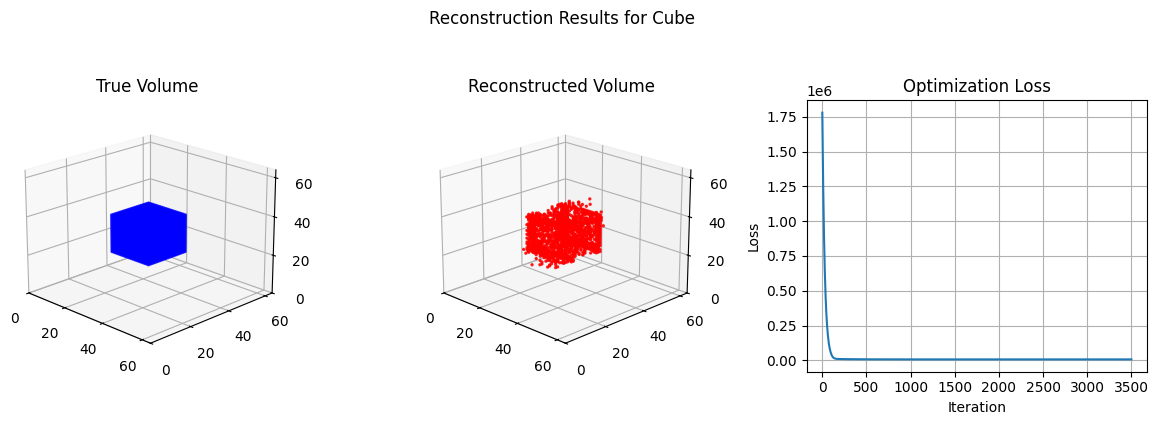

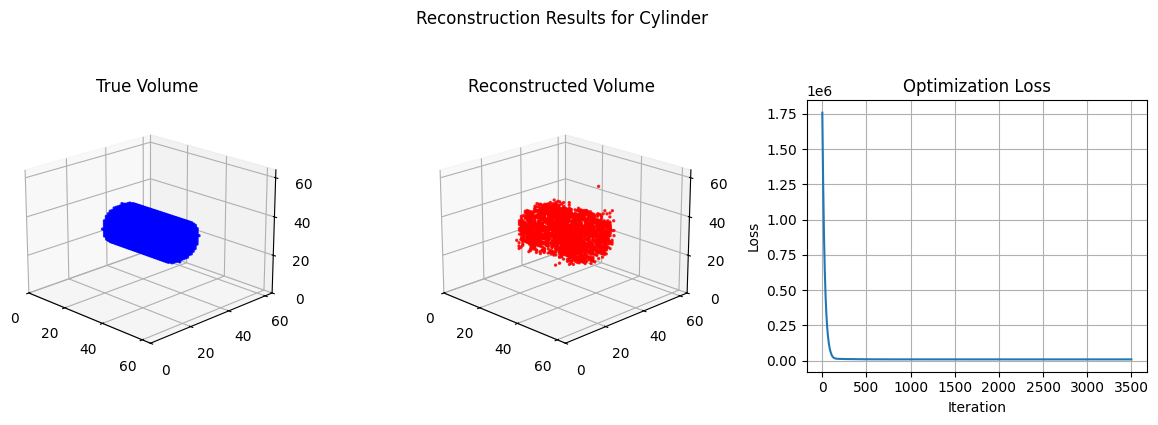

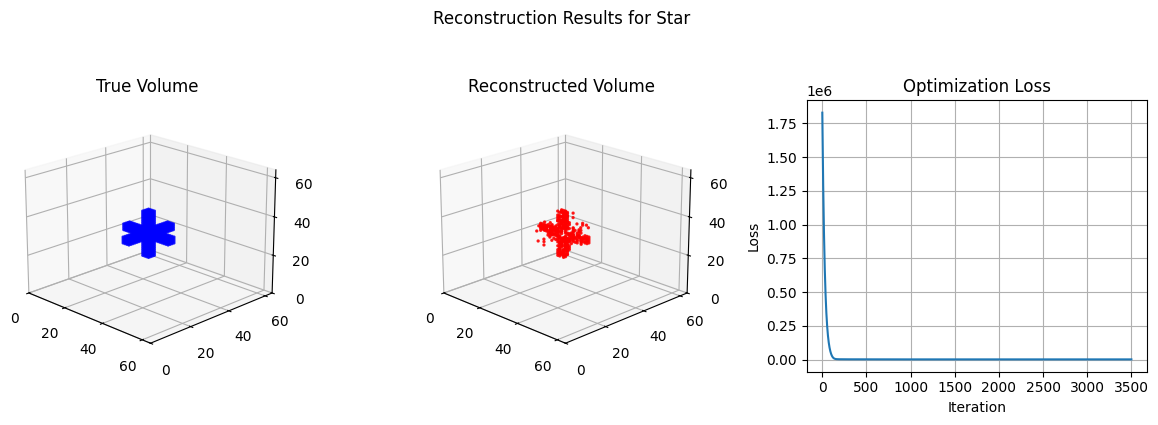

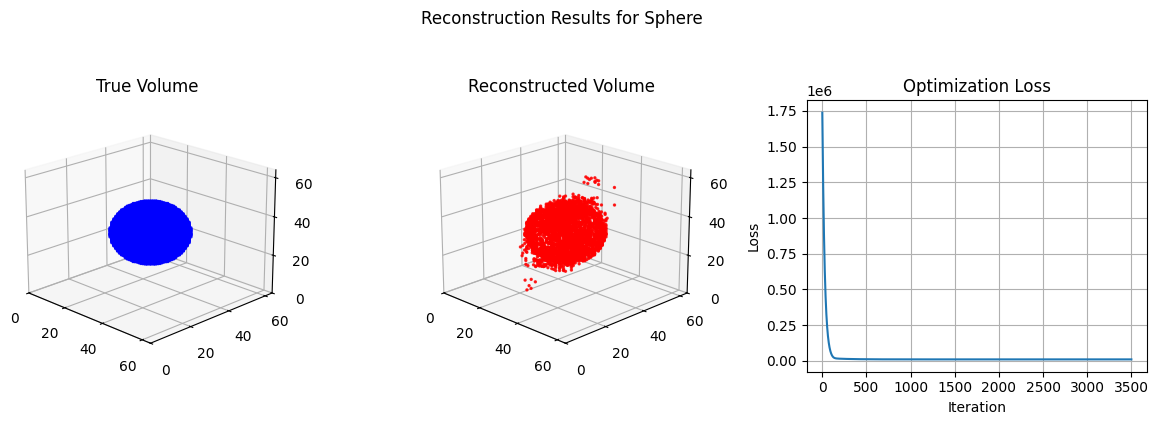

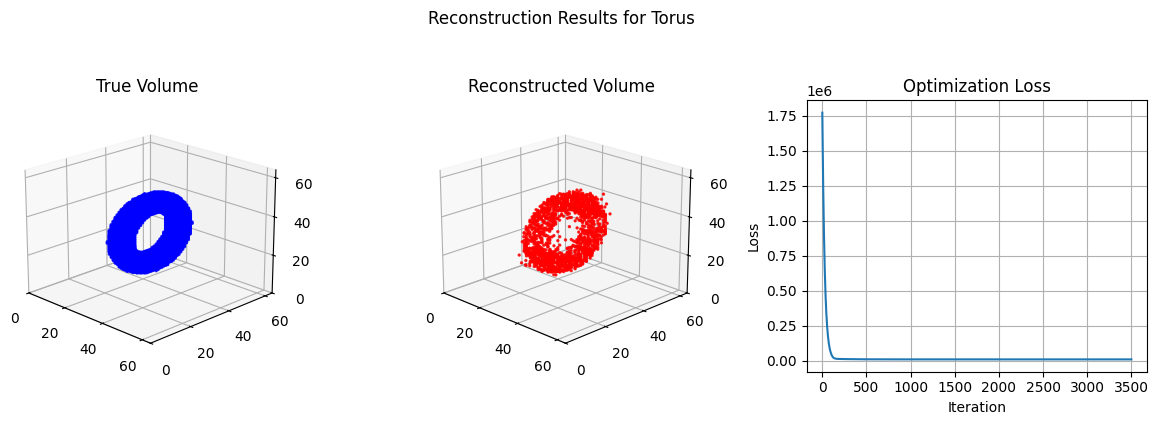

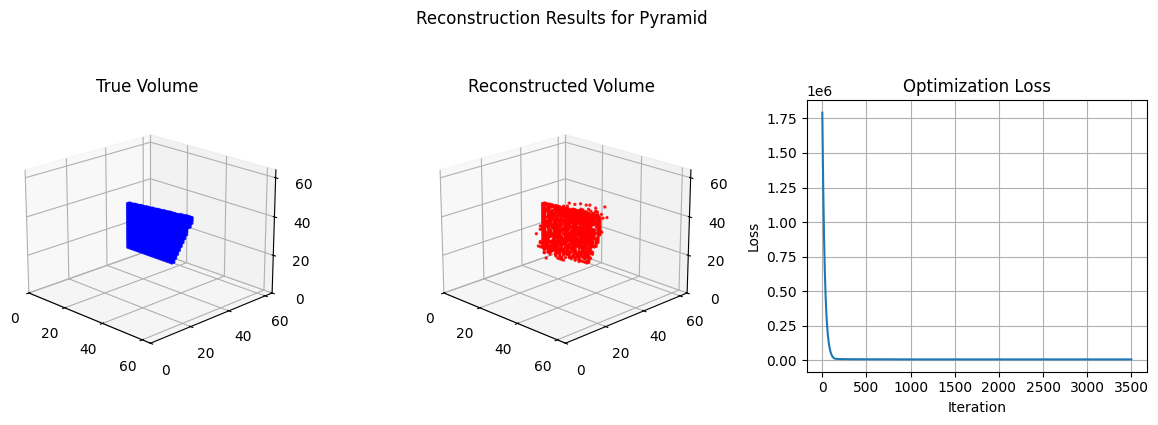

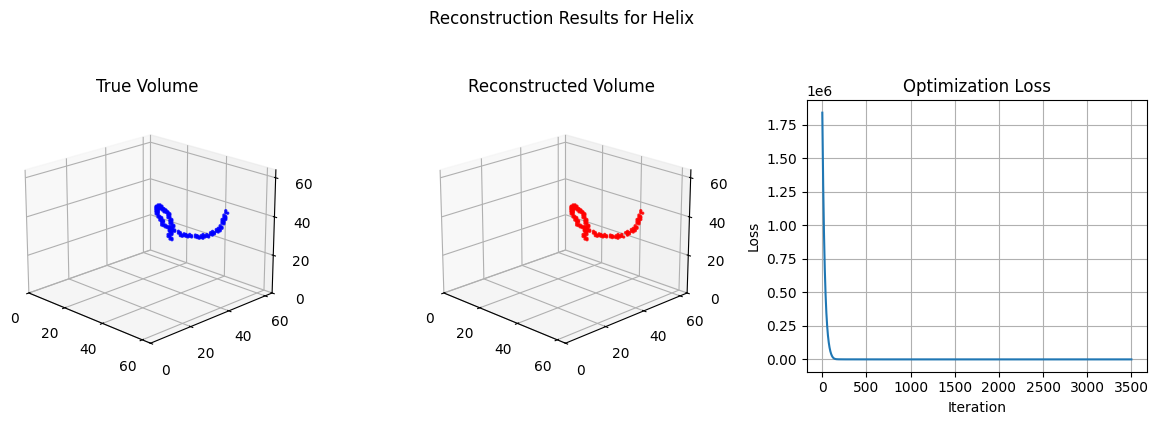

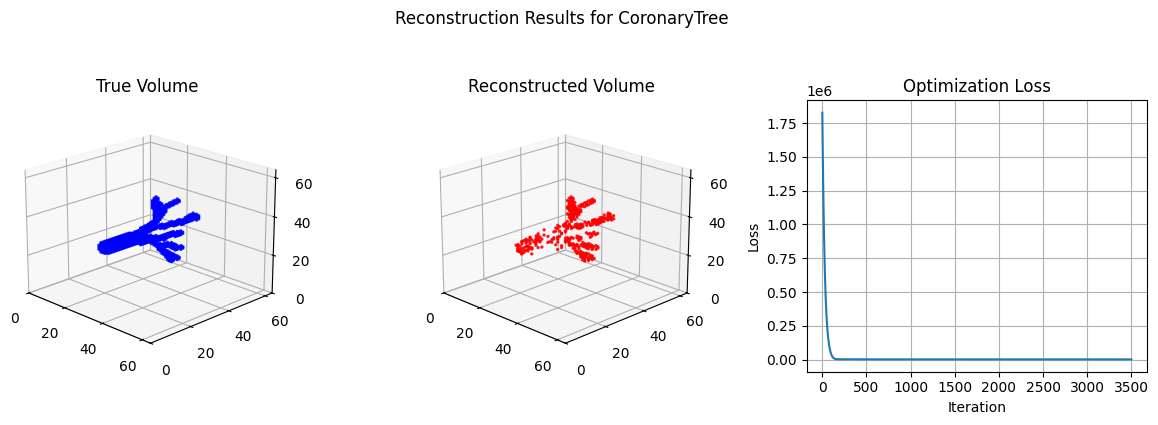

In [17]:
def reconstruct_from_projections(test_objects, projector, num_iterations=3500, lr=0.01):
    """Reconstruct 3D objects from their projections using optimization"""
    results = {}
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nReconstructing {obj_name}...")
        
        # 1. Get the ground truth projections (I_k)
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            #print(I_k.float().max(),I_k.float().min())
            projection_matrices.append(P)

        #P = projection_matrices[0]
        #test_input = torch.ones(volume_shape).flatten().to(device)
        #output = torch.sparse.mm(P, test_input.unsqueeze(-1)).max()
        #print(f"全1输入时的最大投影值: {output.item()}")  # 如果>>1，说明需要归一化

        #P = projection_matrices[0]
        #print(f"Projection matrix max value: {P._values().max().item()}")
        #if P._values().max() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().max())
        #print(f"Projection matrix min value: {P._values().min().item()}")
        #if P._values().min() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().min())
        
        # 2. Initialize the reconstructed volume (relaxed to [0,1])
        X_recon = torch.rand(projector.volume_shape, device=device, requires_grad=True)
        
        # 3. Set up optimizer
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        
        # 4. Optimization loop
        loss_history = []
        best_loss = float('inf')
        best_X = None
        
        for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            
            # Compute all projections
            total_loss = 0
            vec_X = X_recon.flatten()
            
            for P, I_k in zip(projection_matrices, projections):
                # Compute P·vec(X)
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                proj = proj.reshape(I_k.shape)# 不加max operator（也就是可能存在很多值为1的cube投影到同一个pixel）
                #proj = proj.clamp(max=1.0).reshape(I_k.shape)
                
                # Compute Frobenius norm squared
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # Add regularization to encourage binary solutions
            # This helps push values toward 0 or 1
            reg = torch.norm(X_recon * (1 - X_recon), p=1)  # Encourages values to be 0 or 1
            total_loss += 5 * reg
            
            # Track best solution
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_X = X_recon.detach().clone()
            
            loss_history.append(total_loss.item())
            
            # Backpropagate and update
            total_loss.backward()
            if iteration % 100 == 0:
                grad_norm = X_recon.grad.norm().item()
                print(f"Iter {iter}: Loss={total_loss.item():.2f}, Grad Norm={grad_norm:.4f}")
            optimizer.step()
            
            # Project back to [0,1] range
            with torch.no_grad():
                X_recon.data = torch.clamp(X_recon, 0, 1)

        print(total_loss)
        
        # 5. Store results (use the best solution found during optimization)
        threshold = 0.5  # For converting back to binary
        binary_recon = (best_X > threshold).float()
        results[obj_name] = {
            'true': true_volume,
            'reconstructed': binary_recon,
            'relaxed': best_X,
            'loss_history': loss_history
        }
    
    return results

def visualize_reconstruction_results(results):
    """Visualize true and reconstructed volumes"""
    for obj_name, data in results.items():
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f'Reconstruction Results for {obj_name}', y=1.05)
        
        # True volume
        ax1 = fig.add_subplot(131, projection='3d')
        coords = torch.nonzero(data['true']).cpu().numpy()
        if len(coords) > 0:
            ax1.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                      color='blue', s=2, alpha=0.8)
        ax1.set_title('True Volume')
        ax1.set_xlim(0, data['true'].shape[2])
        ax1.set_ylim(0, data['true'].shape[0])
        ax1.set_zlim(0, data['true'].shape[1])
        ax1.view_init(elev=20, azim=-45)
        
        # Reconstructed volume (binary)
        ax2 = fig.add_subplot(132, projection='3d')
        coords = torch.nonzero(data['reconstructed']).cpu().numpy()
        if len(coords) > 0:
            ax2.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                       color='red', s=2, alpha=0.8)
        ax2.set_title('Reconstructed Volume')
        ax2.set_xlim(0, data['reconstructed'].shape[2])
        ax2.set_ylim(0, data['reconstructed'].shape[0])
        ax2.set_zlim(0, data['reconstructed'].shape[1])
        ax2.view_init(elev=20, azim=-45)
        
        # Loss curve
        ax3 = fig.add_subplot(133)
        ax3.plot(data['loss_history'])
        ax3.set_title('Optimization Loss')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    #First visualize the objects and their projections
    visualize_all_objects(test_objects, projector)
    
    # Then perform reconstruction
    reconstruction_results = reconstruct_from_projections(test_objects, projector)
    
    # Visualize reconstruction results
    visualize_reconstruction_results(reconstruction_results)